<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Iteration4_UncertaintyRangeExp_LoanPredict_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Range Experiment
- Dataset : LoanPredict
- Model : RandomForestClassifier
- Reference Dataset : 2010년 (11497, 81)
- Inference Dataset : 2011년 ~ 2018년 (1,323,732, 1)

# 1 구글 드라이브 연결

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 함수 선언



In [94]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp,exp_model_param):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(df_state,x_inf_d,exp_model_param):
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])
    print(permutaion_sigma)
    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data(exp_model_param,x_train,train_gt ):
    temp_X = []
    temp_Y = []
    mean = np.mean(x_train,axis=0)
    std = np.std(x_train,axis=0)
    df_state = pd.DataFrame({"mean":mean,"std":std})

    print('random_sigma_add, mean:',mean)
    print('random_sigma_add, std:',std)

    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train,exp_model_param)
        temp_X.append(random_sigma_add(df_state,x_train[sample_idx],exp_model_param))
        temp_Y.append(train_gt[sample_idx])
    return temp_X, temp_Y

In [3]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
def uncertainty_drift_checker(model_type, train, live, evals=100):
    if model_type == "Classification":
        d_value, p_vale = ks_2samp(entropy(train, axis=-1), entropy(live, axis=-1))

    elif model_type == "Regression":
        train_copy = np.concatenate([train for _ in range(evals)], axis=-1)
        test_copy = np.concatenate([live for _ in range(evals)], axis=-1)
        train_std = np.std(train_copy, axis=-1)
        live_std = np.std(test_copy, axis=-1)
        d_value, p_vale = ks_2samp(train_std, live_std)

    return d_value, p_vale

In [4]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

#4 실험

## 준비

In [5]:
# 실험 모델 환경 설정
import sklearn.metrics as metrics
def acc_fn(y, predict):
    return metrics.accuracy_score(y, predict)*100


def f1_fn(y, predict):
    return metrics.f1_score(y, predict)


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [7]:
main_figsize = (15,3)

def MI_Drift_F1(model, X,y,train_size,test_size,bucket_size=200):

    MIS = {}
    DRF = {}
    F1S = []
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    step_size = int((X.shape[0]-(train_size+test_size))/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tmp_x = X[bk*bucket_size:bk*bucket_size+bucket_size]
        tmp_y = y[bk*bucket_size:bk*bucket_size+bucket_size]
        mi_scores = make_mi_scores(tmp_x,tmp_y , discrete_features="auto")
        ks = __ks_drift(X[0:train_size].values,
                        X[bk*bucket_size+(train_size+test_size):bk*bucket_size+bucket_size+(train_size+test_size)].values)
        predicted_y = model.predict(tmp_x)
        f1_ = metrics.f1_score(tmp_y,(predicted_y > 0.5).astype(float))
        F1S.append(f1_)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[columns].values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[columns].values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(F1S,linewidth=1,label='f1 score')
    plt.ylabel('F1 Score')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1)
    plt.show()

In [92]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

class DriftDetector():
    def __init__(self, threshold,n=3):

        self.threshold = threshold
        self.n = n
        self.current_count = 0
        self.time = 0
        self.value = 0.0

    def detect(self, drift_value):
        if self.current_count >= self.n:
            return True

        if self.threshold < drift_value:
            self.current_count = self.current_count +1
        else:
            self.current_count = 0

        self.value = drift_value
        if self.current_count >= self.n:
            return True

        self.time = self.time + 1
        return False

def experiment(X,y,train_size,test_size,threshold=85):

    seed_everything()

    # Normalize
    scaler_c1 = StandardScaler()
    scaler_c1.fit(X[0:train_size])
    X = pd.DataFrame(scaler_c1.transform(X), columns=columns)
    # Model train...
    model = RandomForestClassifier(max_depth=6).fit(X[0:train_size], y[0:train_size])
    # Dataset 구성
    x_train = X.values[:train_size]
    y_train_gt = y[:train_size].reshape(-1,1)

    mi_scores = make_mi_scores(pd.DataFrame(x_train,columns=columns), y[:train_size], discrete_features="auto")
    max_mi = np.max(mi_scores)
    print('max_mi',max_mi)

    x_test = X[test_size:train_size+test_size].values
    y_test_gt = y[test_size:train_size+test_size].reshape(-1,1)

    x_live = X[test_size:].values
    y_live_gt = y[test_size:].reshape(-1,1)

    print('Structure of dataset, x_train:',x_train.shape, 'x_test:',x_test.shape, 'x_live:',x_live.shape)

    # 기타 parameter 구성
    ######################################### sigma 를 수정
    exp_model_param = {
        "exp_num":[400],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":["acc", "f1"],
        "metric_threshold":[[5,15], [0.05, 0.15]],
        "metric_fn":[acc_fn, f1_fn]
        }

    if max_mi < 0.01:
        exp_model_param['sigma'] = [0,1/max_mi]
        print(exp_model_param['sigma'])

    # 사용할 데이터 및 모델 설정
    predict_fn = model.predict_proba
    model_type = 'Classification'

    # Testset의 Metric 측정
    test_score = []
    # 후미 test_size 개수만 대상.
    y_test = predict_fn(x_test) #[-test_size:])
    print(f'Uncertainty_drift: (y_train={y_train_gt.shape}, y_test={y_test_gt.shape})')
    test_unc, _ = uncertainty_drift_checker(model_type, y_train_gt, y_test_gt)
    metric_name = []
    for i, metric in enumerate(exp_model_param['metric']):
        metric_name.append(metric)
        test_score.append(exp_model_param['metric_fn'][i](y_test_gt, np.argmax(y_test, axis=1).reshape(-1,1)))

    print(f'Testset metric {metric_name}:{test_score}, Testset uncertainty : {test_unc:.5f}')


    y_train = predict_fn(x_train)
    train_gt = y_train_gt

    # Noise 주입!
    exp_X_list, exp_y_list = add_drirft_data(exp_model_param,x_train,train_gt)
    print('Noise set : ',np.asarray(exp_X_list).shape)
    result_d_value = []
    result_score = []
    for idx in tqdm(range(len(exp_X_list))):
        exp_y_train = exp_y_list[idx]
        exp_predict = predict_fn(exp_X_list[idx])
        exp_predict_tmp = predict_fn(exp_X_list[idx])

        # 설정한 Metric을 기반으로 Score 계산
        exp_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            if exp_predict_tmp.shape[1] != 1:
                exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
            exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))

        result_score.append(exp_score)

        # Uncertainty Value 계산
        d_value, _ = uncertainty_drift_checker(model_type,y_train, exp_predict)
        result_d_value.append(d_value)

    result_d_value = np.asarray(result_d_value)
    result_score = np.asarray(result_score)

    exp_lr_model = LinearRegression().fit(result_d_value.reshape(-1, 1),result_score[:,0])

    # Upper, Lower LinearRegression 학습...
    exp_df = pd.DataFrame({'DV':result_d_value,'SC':result_score[:,0]})
    exp_df = exp_df.sort_values(by=['DV'], ascending=True)

    width = 20
    exp_df_set = [exp_df[i:i+width] for i in range(0,exp_df.shape[0],width)]

    # 여기서, upper와 lower 를 나눈다.
    exp_upper = []
    exp_lower = []

    for df_set in exp_df_set:
        mx_set = df_set[df_set['SC'] == np.max(df_set['SC'])]
        mn_set = df_set[df_set['SC'] == np.min(df_set['SC'])]
        exp_upper.append([mx_set['DV'].values[0],mx_set['SC'].values[0]])
        exp_lower.append([mn_set['DV'].values[0],mn_set['SC'].values[0]])

    exp_upper = np.asarray(exp_upper)
    exp_lower = np.asarray(exp_lower)
    #print('exp_upper,',exp_upper.shape)
    #print('exp_lower,',exp_lower.shape)

    exp_up_model = LinearRegression().fit(exp_upper[:,0].reshape(-1, 1),exp_upper[:,1])
    exp_lw_model = LinearRegression().fit(exp_lower[:,0].reshape(-1, 1),exp_lower[:,1])
    #exp_in_model = LinearRegression().fit(result_score[:,0].reshape(-1, 1),result_d_value)


    ############################# 보정 처리 ############################
    # 실험 LinearRegression의 Y 절편 (drift가 없을 때의 metric) 을 testset의 metric에 맞춤
    # 실험 drift(uncen)의 최소값을 testset의 drift(uncen)에 맞춤
    delta = test_score[0] - exp_lw_model.intercept_
    print(f'Y Adjustment:{delta:.5f}')

    delta_x = np.min(result_d_value) - test_unc
    print(f'X Adjustment:{delta_x:.5f}')
    ######################################################################
    # real data의 score vs drift 취득
    live_set = []
    live_set_y = []
    truncate_count = 0
    bucket_size=(train_size,test_size)
    for i in range(int(x_live.shape[0]/bucket_size[1])):
        xl = x_live[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        yl = y_live_gt[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        if len(xl) ==  train_size:
            live_set.append(xl)
            live_set_y.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {x_live.shape}')

    live_set = np.asarray(live_set)
    live_set_y = np.asarray(live_set_y)

    real_scores = []
    real_d_value = []
    print('Live set : ',live_set.shape)
    for live_unit,live_unit_y in zip(tqdm(live_set), live_set_y):#tqdm(zip(live_set,live_set_y)):
        predicted_y = predict_fn(live_unit)

        # 설정한 Metric을 기반으로 Score 계산
        real_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            if predicted_y.shape[1] != 1:
                predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
            real_score.append(exp_model_param['metric_fn'][i](live_unit_y, (predicted_y > 0.5).astype(float)))
        real_scores.append(real_score)

        # Uncertainty Value 계산
        d_value, _ = uncertainty_drift_checker(model_type,live_unit_y.reshape(-1,1), predicted_y)
        real_d_value.append(d_value)

    real_d_value = np.asarray(real_d_value)
    real_scores = np.asarray(real_scores)

    real_lr_model = LinearRegression().fit(real_d_value.reshape(-1, 1),real_scores[:,0])
    #real_in_model = LinearRegression().fit(real_scores[:,0].reshape(-1, 1),real_d_value)

    dd = np.concatenate((result_d_value,real_d_value),axis=0)

    d_min = np.min(dd)
    d_max = np.max(dd)
    xsx = np.arange(d_min-(d_max-d_min)/100,d_max,(d_max-d_min)/100)

    plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    plt.show()

    plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
    plt.scatter(exp_lower[:,0],exp_lower[:,1],marker='.',linewidth=2,label='lw exp')

    plt.plot(xsx,exp_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_line')

    plt.plot(xsx,exp_up_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_up_line')
    plt.plot(xsx,exp_lw_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_) / exp_lr_model.coef_[0]
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')

    print("################ 보정 처리 ###############")

    plt.scatter(result_d_value-delta_x,result_score[:,0]+delta,marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')

    plt.plot(xsx-delta_x,exp_lr_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_line')

    plt.plot(xsx-delta_x,exp_up_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_up_line')
    plt.plot(xsx-delta_x,exp_lw_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_ - delta) / exp_lr_model.coef_[0] - delta_x
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')

    plt.figure(figsize=(15,3))
    predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))+delta
    plt.plot(predict_scores,linewidth=1,label='exp score (adj)')
    # 보정한 결과로 R2 측정
    plt.plot(real_scores[:,0],linewidth=2,label='real score')
    predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))
    plt.plot(predict_scores,linewidth=1,linestyle = ':', label='exp score')

    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    print(f'r2 of expected metric vs real metric :{metrics.r2_score(real_scores[:,0],predict_scores):.5f}')


    plt.figure(figsize=(15,3))
    plt.plot(real_d_value,linewidth=1,label='uncen value')
    #plt.axhline(y = test_unc, color = 'b', linestyle = ':',label='test_uncen')
    #th1 = test_unc + test_unc * 0.1
    #th2 = test_unc + test_unc * 0.2
    th3 = test_unc + test_unc * 0.3
    #plt.axhline(y = th1, linestyle = ':',label='test_uncen(10%)')
    #plt.axhline(y = th2, linestyle = ':',label='test_uncen(20%)')
    plt.axhline(y = exp_d_value, linestyle = ':',color = 'r', label='expected uncertainty')

    # test_uncen(30%)을 threshold로 설정, 3회 연속 over일 경우, detect
    ddd = DriftDetector(exp_d_value,2)
    dt = [ddd.detect(v) for v in real_d_value]
    if np.sum(dt) > 0:
        plt.axvline(x = ddd.time, color='r', linestyle = ':',label='detect')
        print(f'Detect at {ddd.time} time, uncertainty {ddd.value:.5f} metric {real_scores[ddd.time,0]:.5f}')
    else:
        print('Detect fail!!')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()



## Case #1 MI의 감소, Drift의 증가

In [25]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(0,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)


columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[93.27777777777779, 0.9330381848367459], Testset uncertainty : 0.00333
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:23<00:00, 16.91it/s]


Y Adjustment:-0.09425
X Adjustment:-0.00278
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:06<00:00, 31.67it/s]


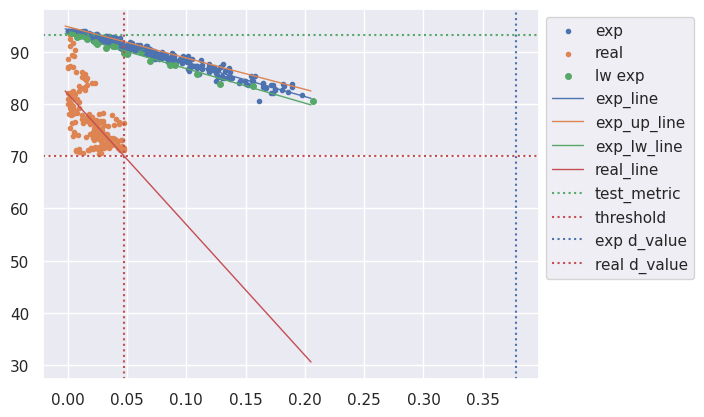

expected_uncertainty @ threshold 70 : 0.37802
    real_uncertainty @ threshold 70 : 0.04784
threshold error : 0.33018
################ 보정 처리 ###############


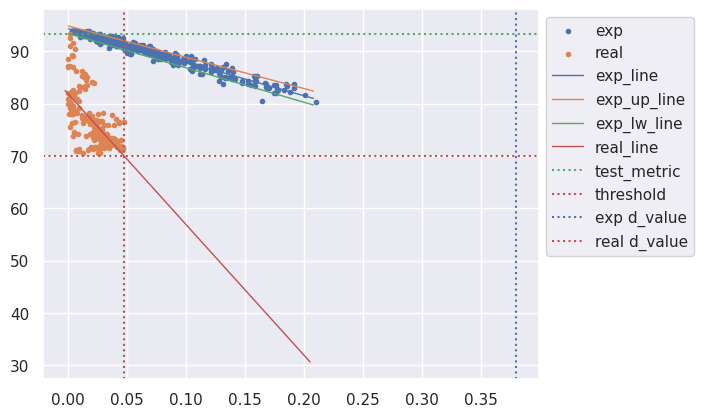

expected_uncertainty @ threshold 70 : 0.37933
    real_uncertainty @ threshold 70 : 0.04784
threshold error : 0.33149


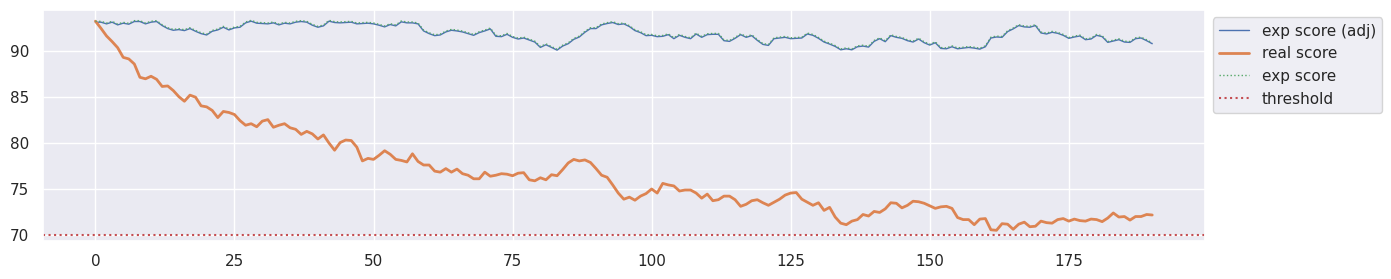

r2 of expected metric vs real metric :-8.64960
Detect fail!!


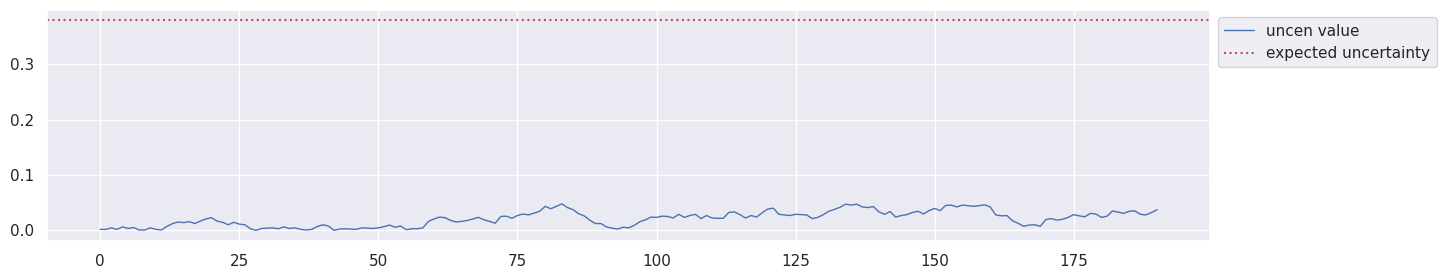

In [26]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=70)

## Case #2 MI의 증감(상대적), Drift의 고정

In [27]:

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)


m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

5
21426
z0    0.123425
x0    0.079212
x1    0.032962
x2    0.008752
x3    0.007456
Name: MI Scores, dtype: float64


In [28]:
X = X1
y = np.asarray(y1)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[94.38888888888889, 0.9522909777987718], Testset uncertainty : 0.00167
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:23<00:00, 17.08it/s]


Y Adjustment:1.00176
X Adjustment:-0.00111
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:06<00:00, 31.60it/s]


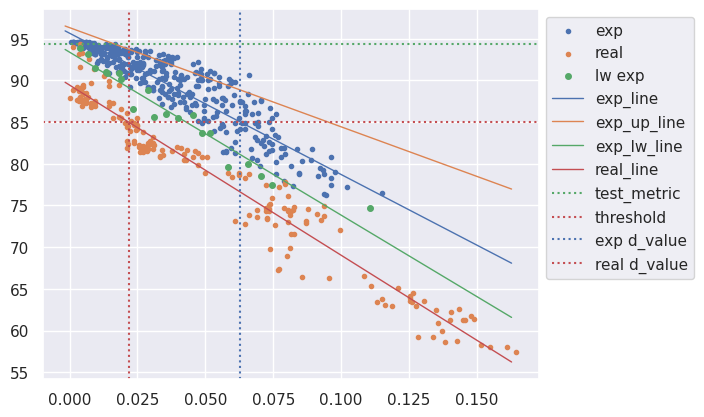

expected_uncertainty @ threshold 85 : 0.06293
    real_uncertainty @ threshold 85 : 0.02175
threshold error : 0.04118
################ 보정 처리 ###############


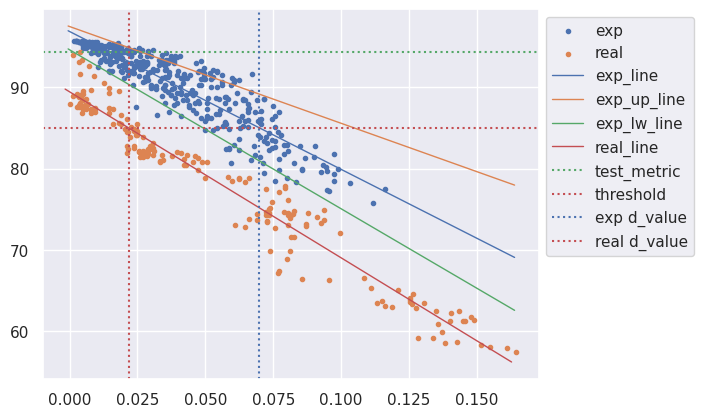

expected_uncertainty @ threshold 85 : 0.06995
    real_uncertainty @ threshold 85 : 0.02175
threshold error : 0.04820


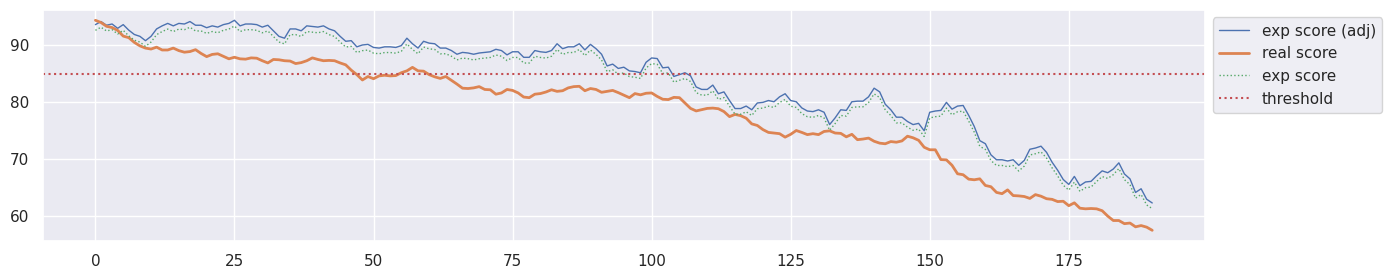

r2 of expected metric vs real metric :0.72853
Detect at 115 time, uncertainty 0.07944 metric 77.83333


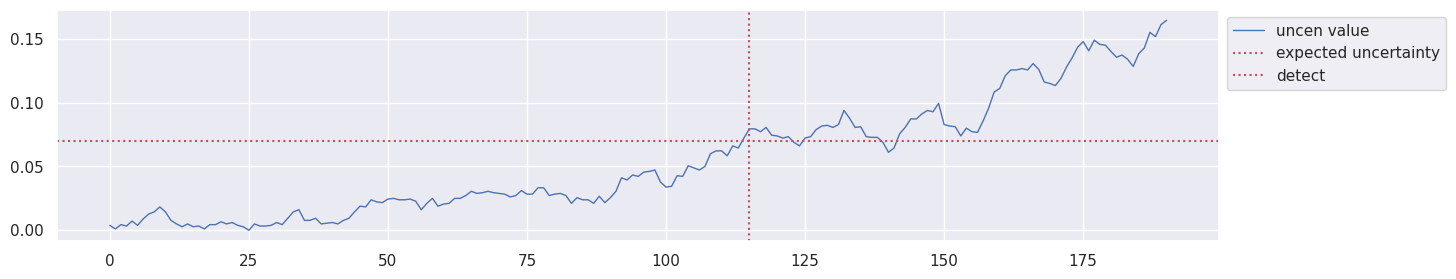

In [29]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,threshold=85)

## Case #3 MI의 증감(상대적), Drift의 증가

In [75]:

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

7.2404412558678075
z0    0.269203
x0    0.077964
x1    0.028502
x2    0.012955
x3    0.001920
Name: MI Scores, dtype: float64


In [76]:
X = X2
y = np.asarray(y2)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[97.94444444444444, 0.9456681350954479], Testset uncertainty : 0.00389
random_sigma_add, mean: [-3.15765932e-16 -8.31429832e-16 -1.47104551e-15  5.44749431e-16
  2.66576884e-15]
random_sigma_add, std: [1. 1. 1. 1. 1.]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:22<00:00, 17.91it/s]


Y Adjustment:-0.05504
X Adjustment:-0.00333
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:05<00:00, 33.59it/s]


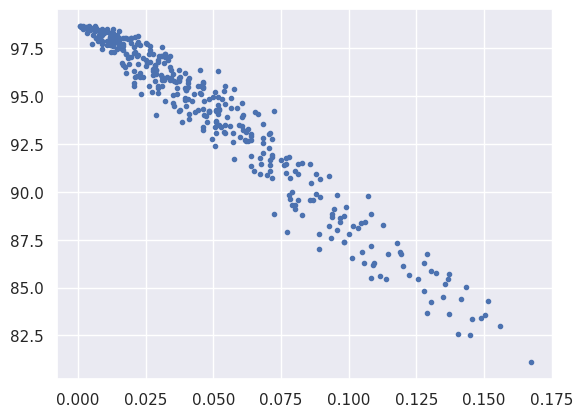

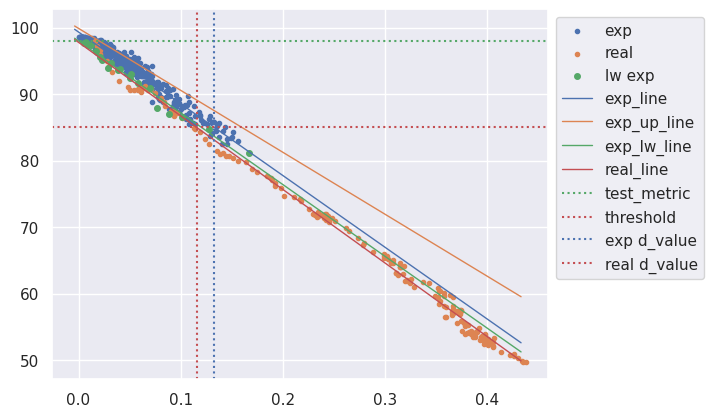

expected_uncertainty @ threshold 85 : 0.13305
    real_uncertainty @ threshold 85 : 0.11575
threshold error : 0.01730
################ 보정 처리 ###############


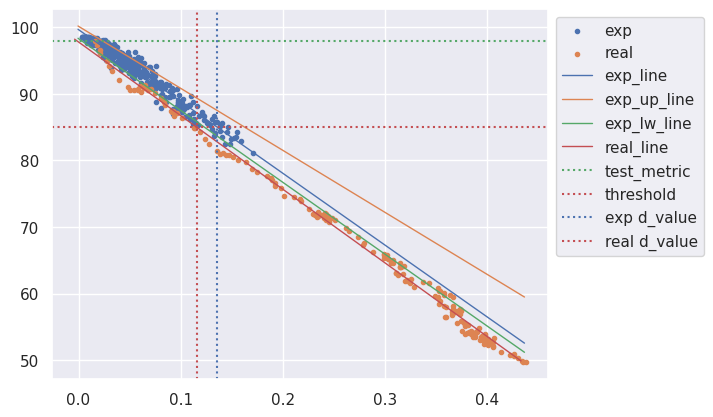

expected_uncertainty @ threshold 85 : 0.13587
    real_uncertainty @ threshold 85 : 0.11575
threshold error : 0.02012


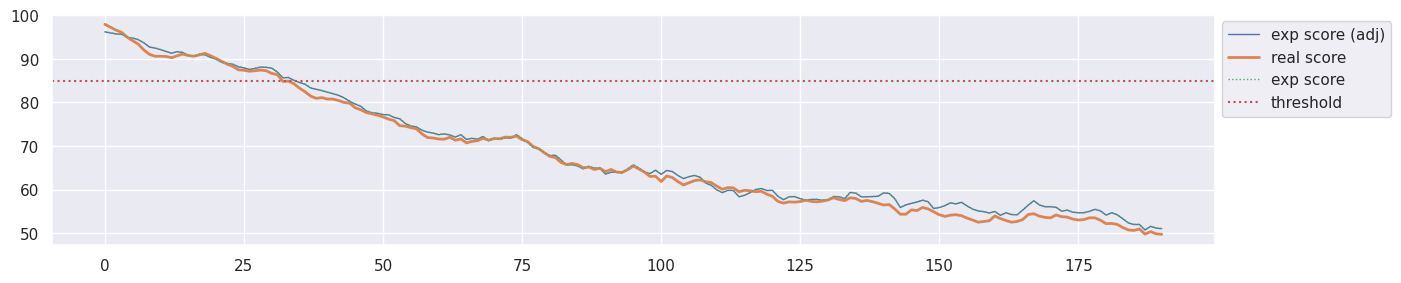

r2 of expected metric vs real metric :0.99064
Detect at 39 time, uncertainty 0.14111 metric 81.11111


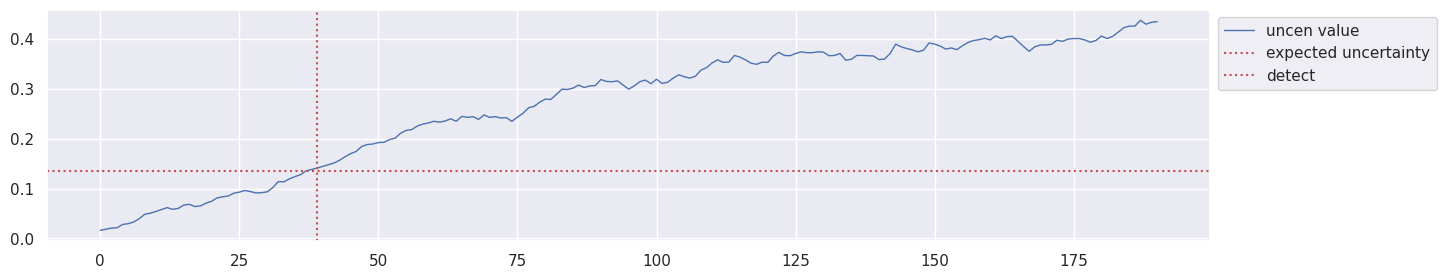

In [77]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #4 MI의 고정, Drift의 증가

In [33]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)

columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [34]:
X = X3
y = np.asarray(y3)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[95.77777777777777, 0.9584699453551913], Testset uncertainty : 0.00333
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:23<00:00, 17.33it/s]


Y Adjustment:-0.49053
X Adjustment:-0.00278
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:06<00:00, 31.15it/s]


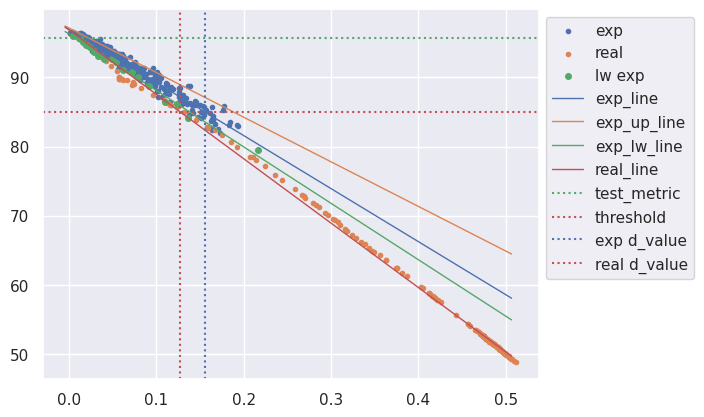

expected_uncertainty @ threshold 85 : 0.15546
    real_uncertainty @ threshold 85 : 0.12736
threshold error : 0.02811
################ 보정 처리 ###############


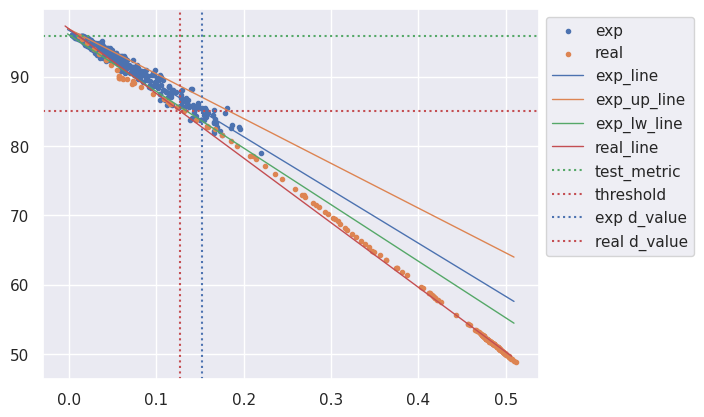

expected_uncertainty @ threshold 85 : 0.15185
    real_uncertainty @ threshold 85 : 0.12736
threshold error : 0.02449


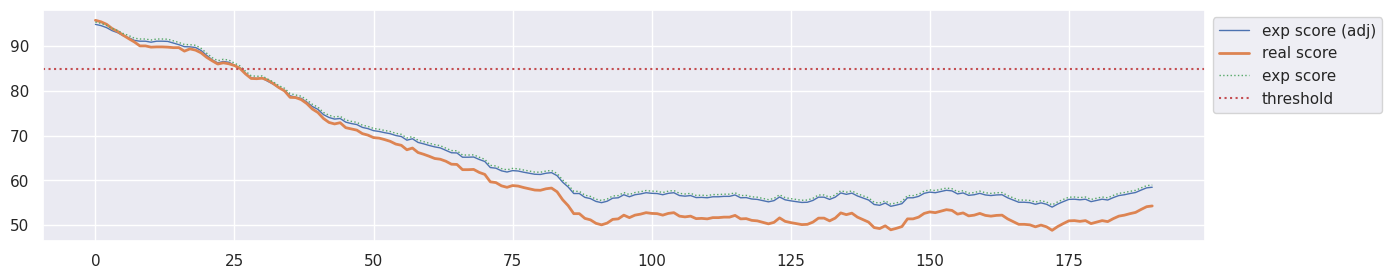

r2 of expected metric vs real metric :0.91547
Detect at 29 time, uncertainty 0.15944 metric 82.72222


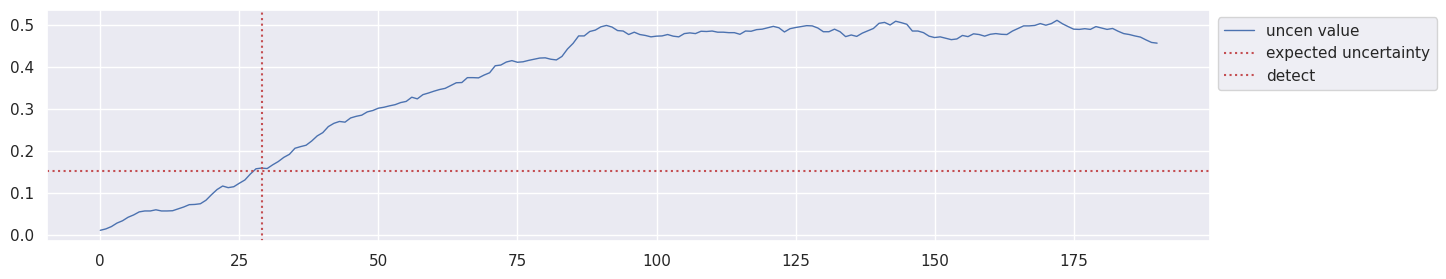

In [35]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #5 Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우

In [36]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

x3    0.145527
x2    0.113997
z0    0.092832
x0    0.043090
x1    0.024980
Name: MI Scores, dtype: float64


In [37]:
X = X4
y = np.asarray(y4)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[96.77777777777777, 0.9727187206020697], Testset uncertainty : 0.00333
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:23<00:00, 17.33it/s]


Y Adjustment:0.44661
X Adjustment:-0.00278
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:05<00:00, 33.14it/s]


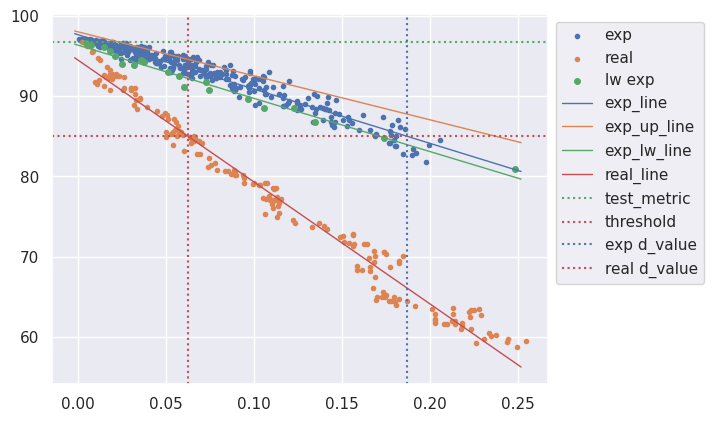

expected_uncertainty @ threshold 85 : 0.18692
    real_uncertainty @ threshold 85 : 0.06243
threshold error : 0.12449
################ 보정 처리 ###############


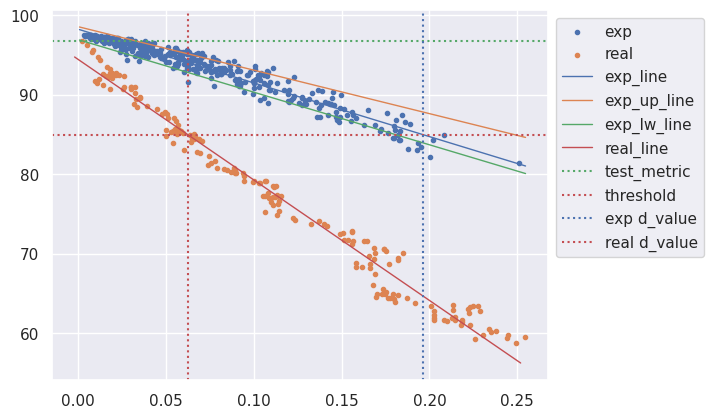

expected_uncertainty @ threshold 85 : 0.19630
    real_uncertainty @ threshold 85 : 0.06243
threshold error : 0.13387


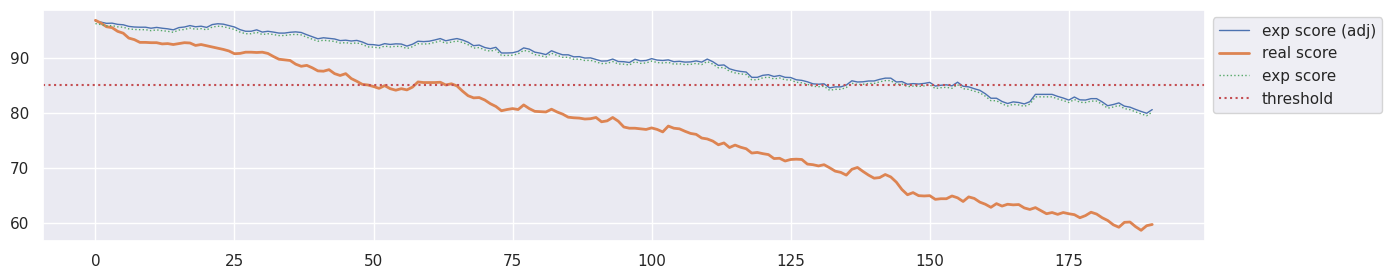

r2 of expected metric vs real metric :-0.46269
Detect at 161 time, uncertainty 0.21333 metric 62.88889


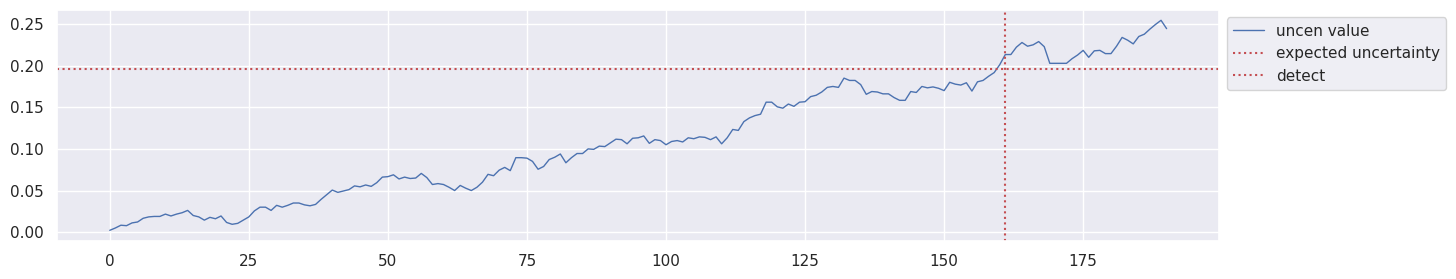

In [38]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #6 Case #3,4의 상황이 각 feature에 혼재되어 있는 경우

In [39]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

z0    0.254714
x3    0.067504
x1    0.043212
x0    0.026915
x2    0.001097
Name: MI Scores, dtype: float64


In [40]:
X = X4
y = np.asarray(y4)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
Uncertainty_drift: (y_train=(1800, 1), y_test=(1800, 1))
Testset metric ['acc', 'f1']:[92.72222222222221, 0.9392111368909513], Testset uncertainty : 0.00333
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:23<00:00, 17.28it/s]


Y Adjustment:0.16354
X Adjustment:-0.00278
Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:05<00:00, 33.28it/s]


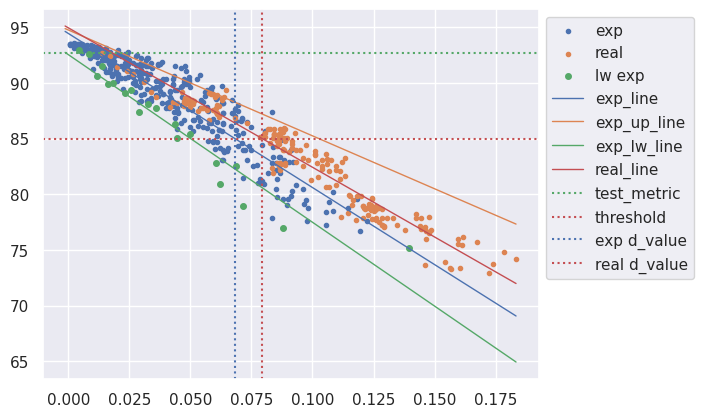

expected_uncertainty @ threshold 85 : 0.06830
    real_uncertainty @ threshold 85 : 0.07950
threshold error : 0.01120
################ 보정 처리 ###############


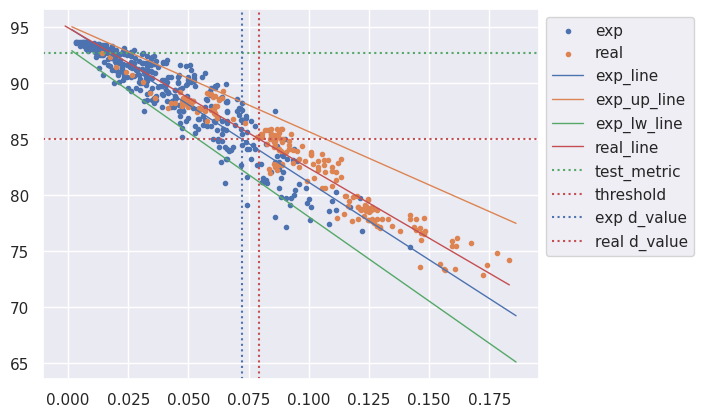

expected_uncertainty @ threshold 85 : 0.07226
    real_uncertainty @ threshold 85 : 0.07950
threshold error : 0.00724


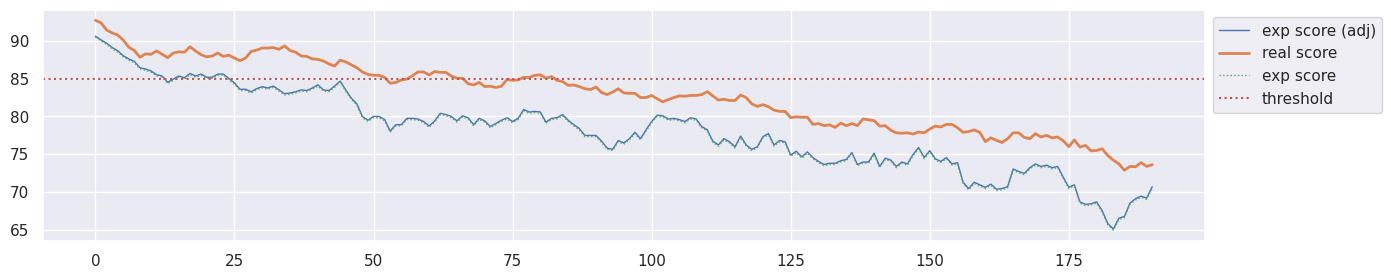

r2 of expected metric vs real metric :-0.22384
Detect at 48 time, uncertainty 0.08444 metric 85.88889


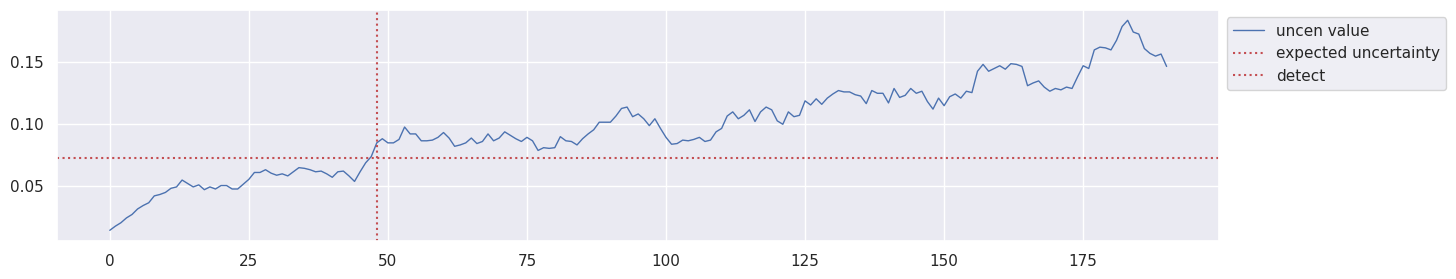

In [41]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Real-world data(Loan data)의 실험

In [42]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [43]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [44]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [45]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df_accepted.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [46]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [47]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375597
last_fico_range_high    0.094848
last_pymnt_amnt         0.086180
total_rec_late_fee      0.038199
int_rate                0.018675
                          ...   
G1                      0.000000
F5                      0.000000
F4                      0.000000
D5                      0.000000
loan_amnt               0.000000
Name: MI Scores, Length: 81, dtype: float64


### Loan Data 실험

In [223]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

#### 실험 #1 Top 1~5, 4개의 feature 적용

In [224]:
top_columns = list(mi_scores[1:5].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

In [225]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2]

In [226]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


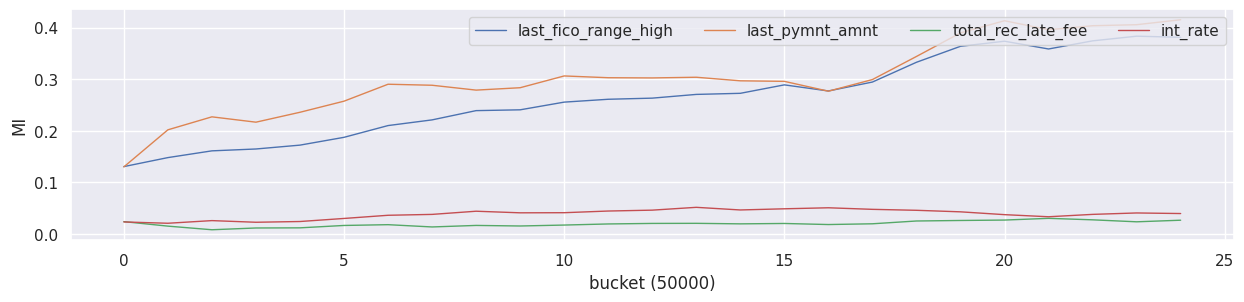

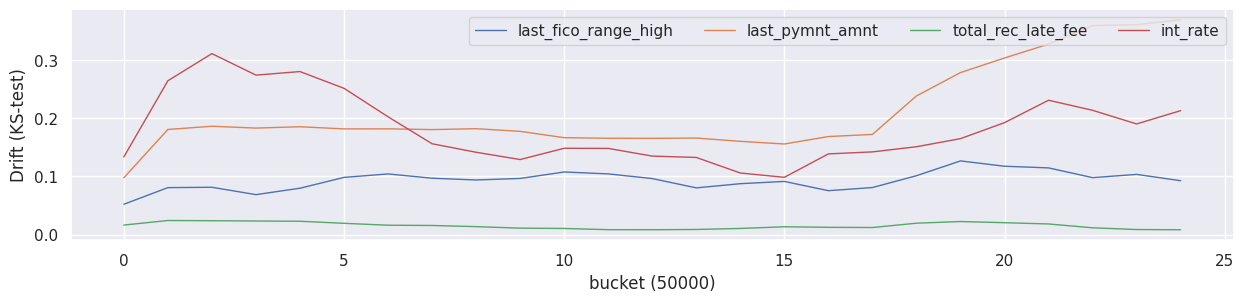

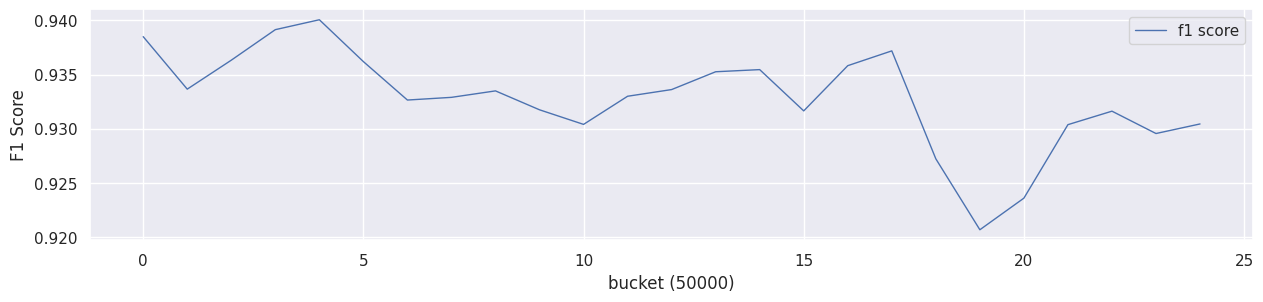

In [227]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

In [229]:
Xr = X2
yr = np.asarray(Y2)

Structure of dataset, x_train: (10000, 4) x_test: (10000, 4) x_live: (1278533, 4)
Uncertainty_drift: (y_train=(10000, 1), y_test=(10000, 1))
Testset metric ['acc', 'f1']:[90.42999999999999, 0.9468185607113088], Testset uncertainty : 0.00120
Noise set :  (400, 10000, 4)


100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


Y Adjustment:1.05723
X Adjustment:-0.00100
Truncate 47492 rows from live_set (1278533, 4)
Live set :  (1106, 10000, 4)


100%|██████████| 1106/1106 [01:55<00:00,  9.55it/s]


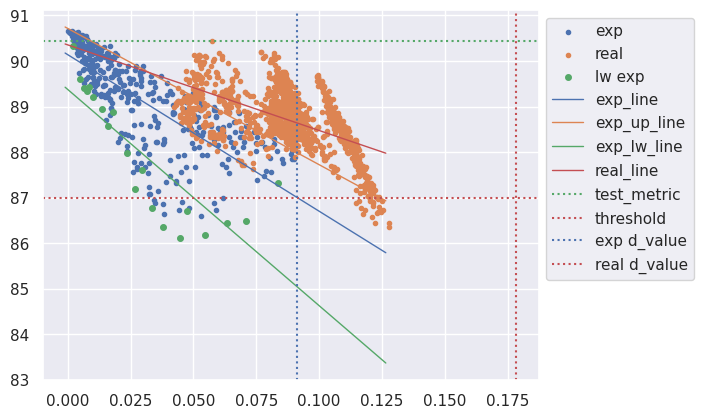

expected_uncertainty @ threshold 87 : 0.09124
    real_uncertainty @ threshold 87 : 0.17834
threshold error : 0.08710
################ 보정 처리 ###############


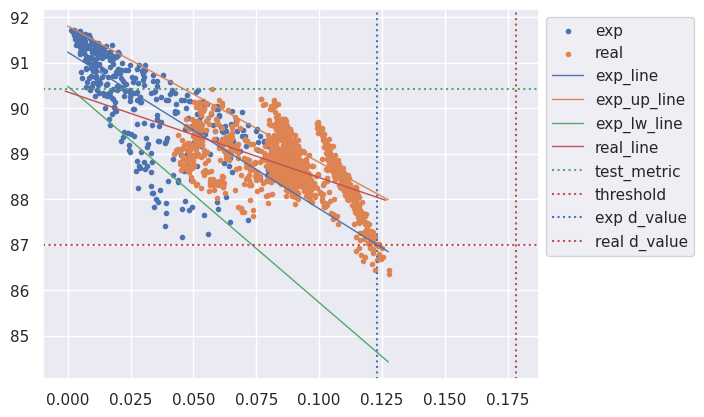

expected_uncertainty @ threshold 87 : 0.12299
    real_uncertainty @ threshold 87 : 0.17834
threshold error : 0.05535


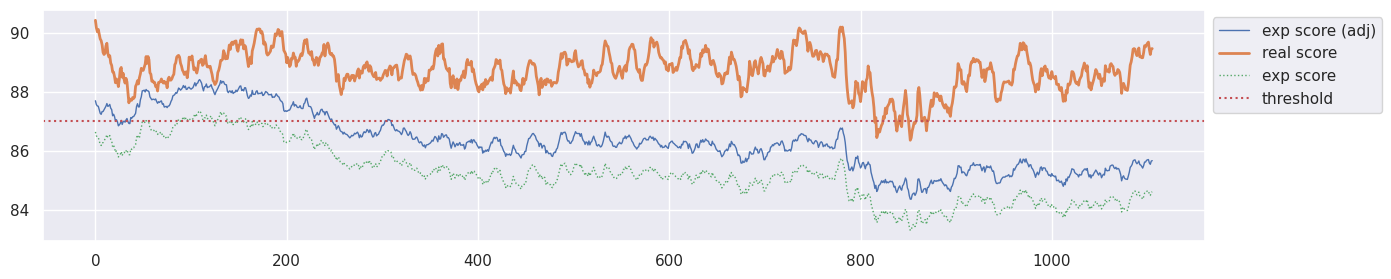

r2 of expected metric vs real metric :-28.21065
Detect at 852 time, uncertainty 0.12780 metric 86.36000


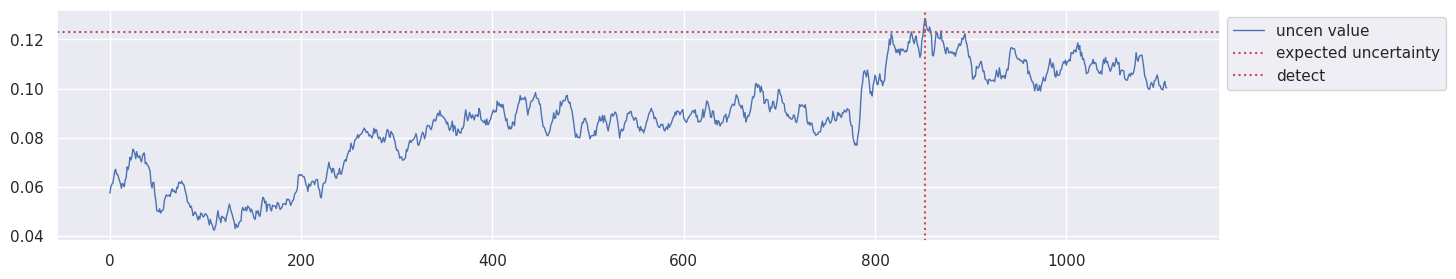

In [230]:
train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=87)

#### 실험 #2 Top 3~5 2개의 feature 사용

In [231]:
top_columns = list(mi_scores[3:5].index)
top_columns

['total_rec_late_fee', 'int_rate']

In [232]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[14, 2]

In [233]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


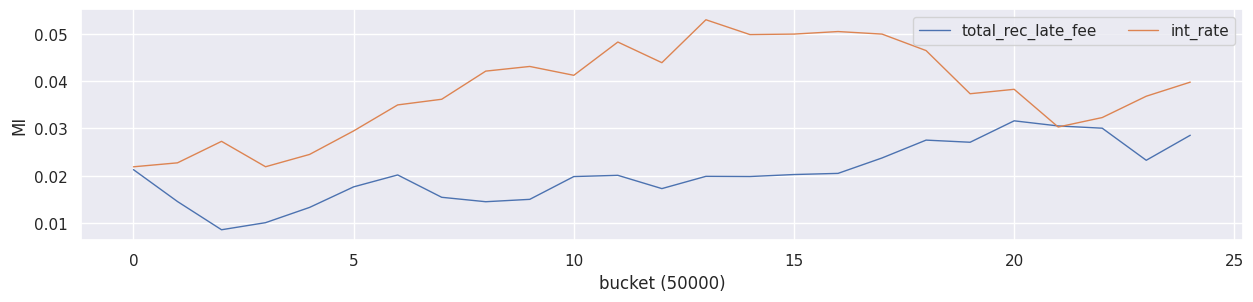

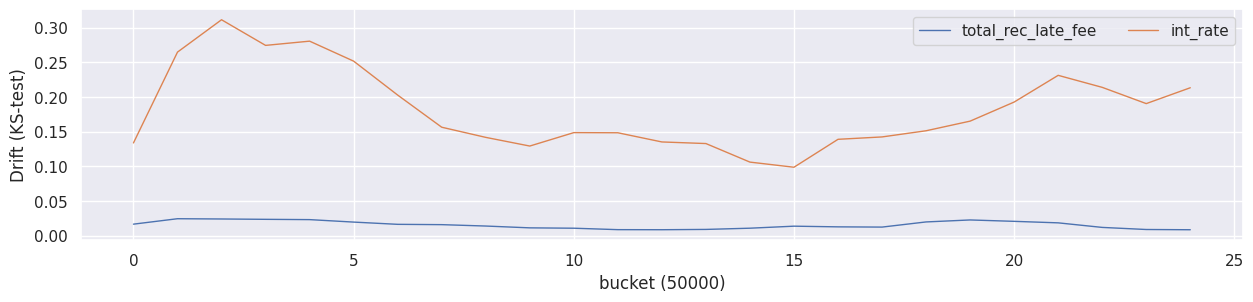

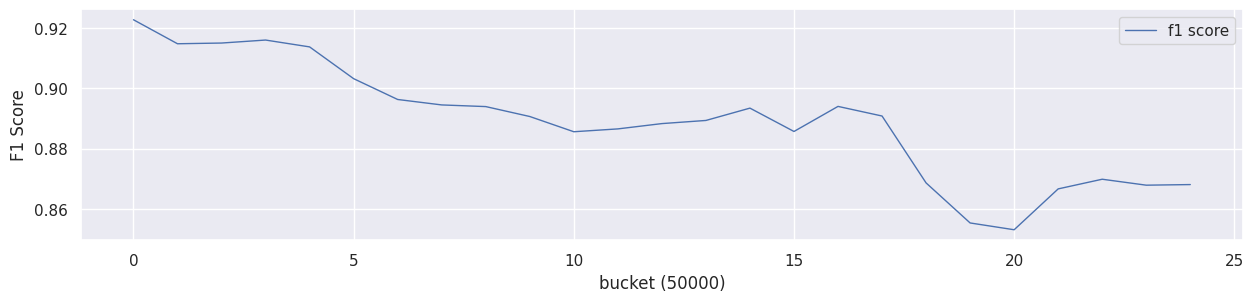

In [234]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 2) x_test: (10000, 2) x_live: (1278533, 2)
Uncertainty_drift: (y_train=(10000, 1), y_test=(10000, 1))
Testset metric ['acc', 'f1']:[88.3, 0.9370222844224352], Testset uncertainty : 0.00120
Noise set :  (400, 10000, 2)


100%|██████████| 400/400 [01:21<00:00,  4.91it/s]


Y Adjustment:0.66897
X Adjustment:-0.00080
Truncate 47492 rows from live_set (1278533, 2)
Live set :  (1106, 10000, 2)


100%|██████████| 1106/1106 [01:58<00:00,  9.33it/s]


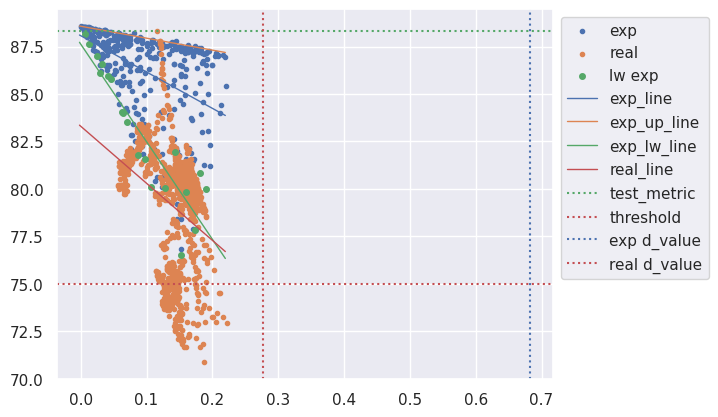

expected_uncertainty @ threshold 75 : 0.68306
    real_uncertainty @ threshold 75 : 0.27621
threshold error : 0.40685
################ 보정 처리 ###############


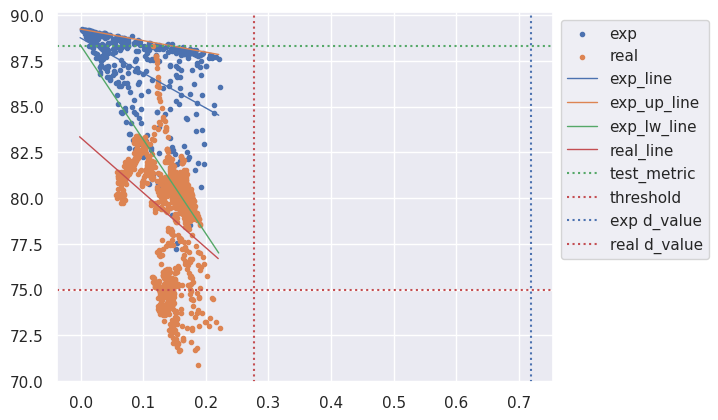

expected_uncertainty @ threshold 75 : 0.71881
    real_uncertainty @ threshold 75 : 0.27621
threshold error : 0.44260


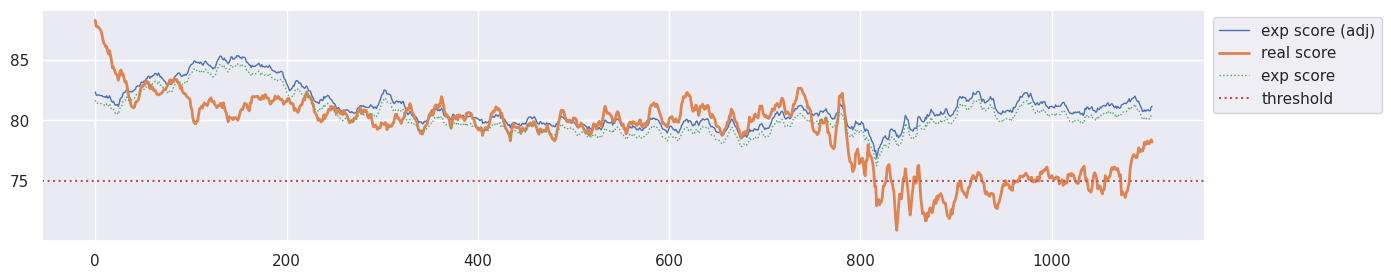

r2 of expected metric vs real metric :-0.13698
Detect fail!!


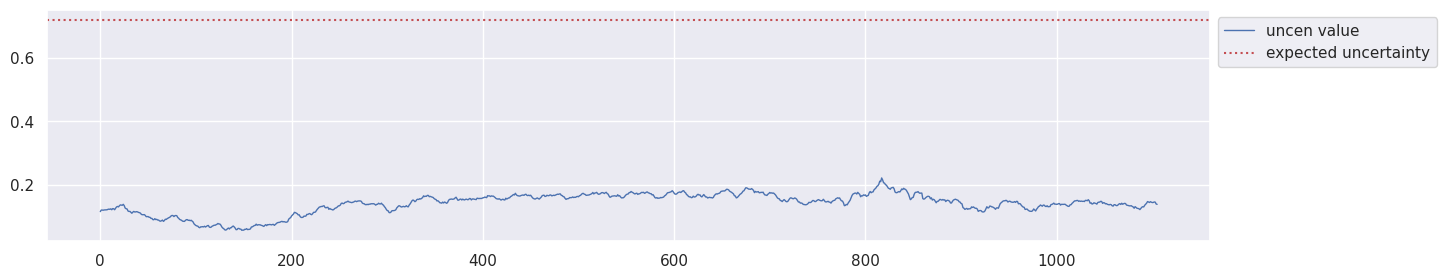

In [237]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147
live_size = 50000
columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=75)

#### 실험 #3 Top 1~3 2개의 feature 사용

In [238]:
top_columns = list(mi_scores[1:3].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt']

In [239]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


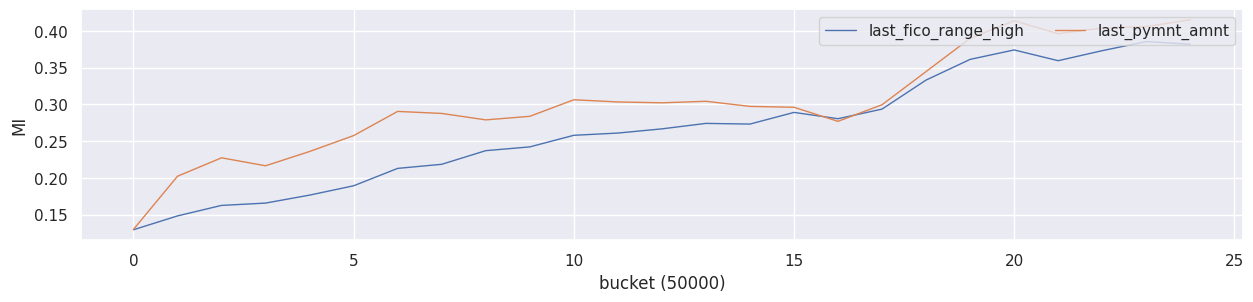

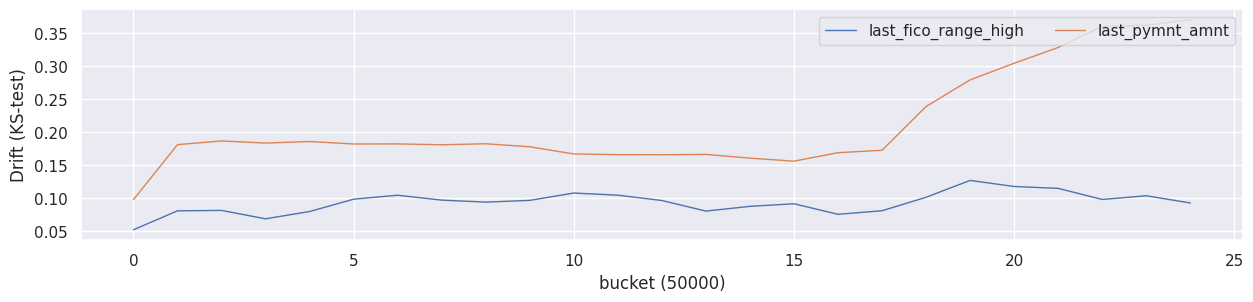

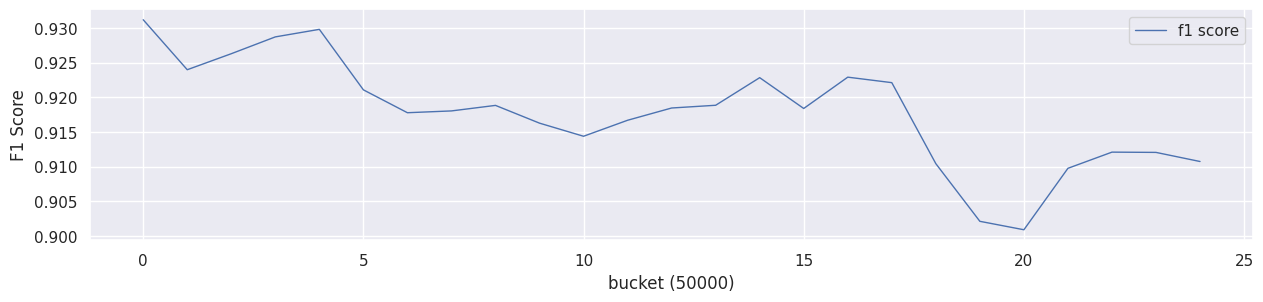

In [240]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 2) x_test: (10000, 2) x_live: (1278533, 2)
Uncertainty_drift: (y_train=(10000, 1), y_test=(10000, 1))
Testset metric ['acc', 'f1']:[89.25, 0.9406438076307216], Testset uncertainty : 0.00120
Noise set :  (400, 10000, 2)


100%|██████████| 400/400 [01:19<00:00,  5.03it/s]


Y Adjustment:0.29672
X Adjustment:-0.00090
Truncate 47492 rows from live_set (1278533, 2)
Live set :  (1106, 10000, 2)


100%|██████████| 1106/1106 [01:55<00:00,  9.56it/s]


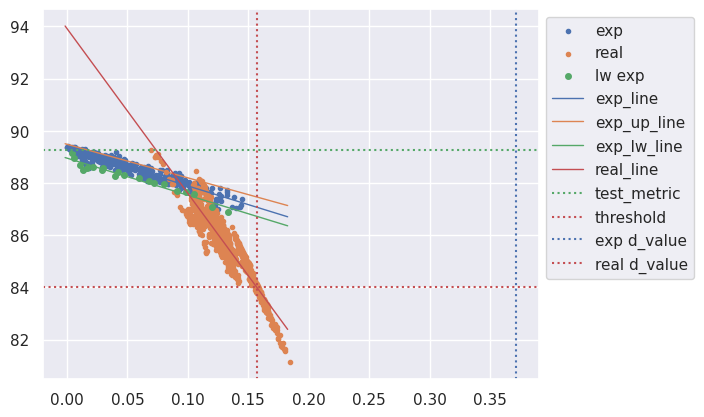

expected_uncertainty @ threshold 84 : 0.37150
    real_uncertainty @ threshold 84 : 0.15708
threshold error : 0.21442
################ 보정 처리 ###############


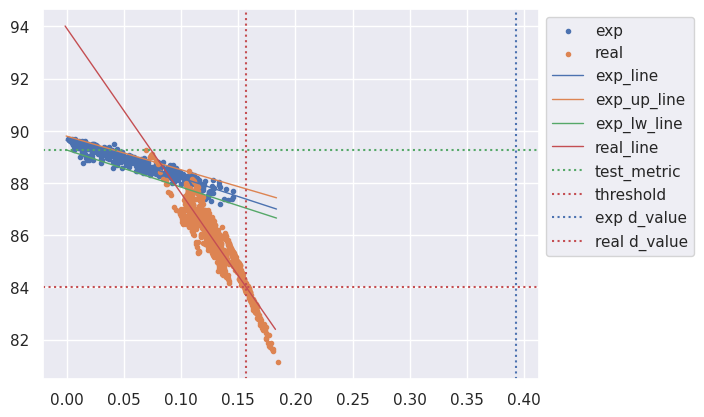

expected_uncertainty @ threshold 84 : 0.39312
    real_uncertainty @ threshold 84 : 0.15708
threshold error : 0.23604


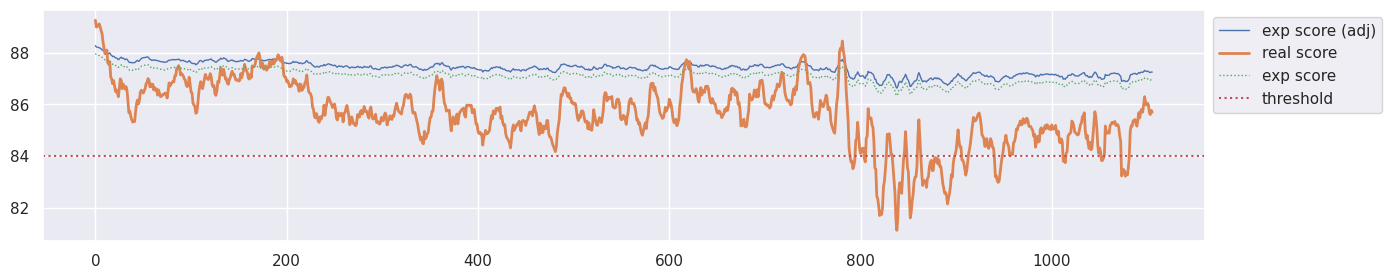

r2 of expected metric vs real metric :-1.05190
Detect fail!!


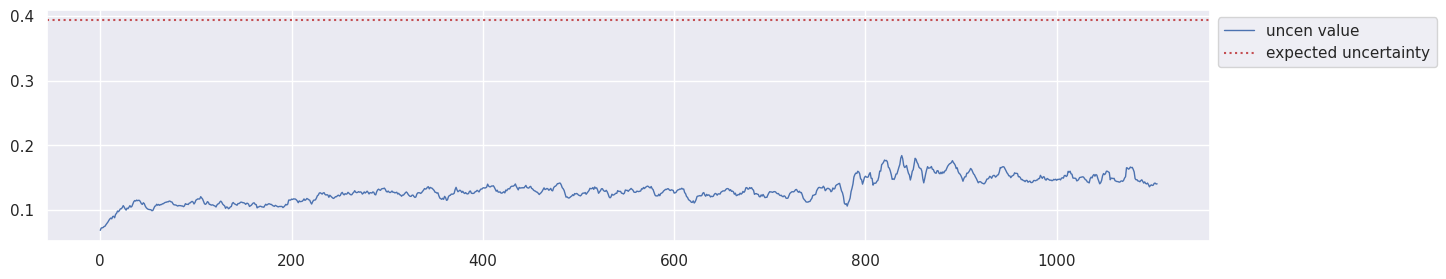

In [241]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=84)

#### 실험 #4 Top 0~10 10개의 feature 사용 --> 사실상 의미 있는 모든 feature 사용

Bucket size 50000 step_size 25


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


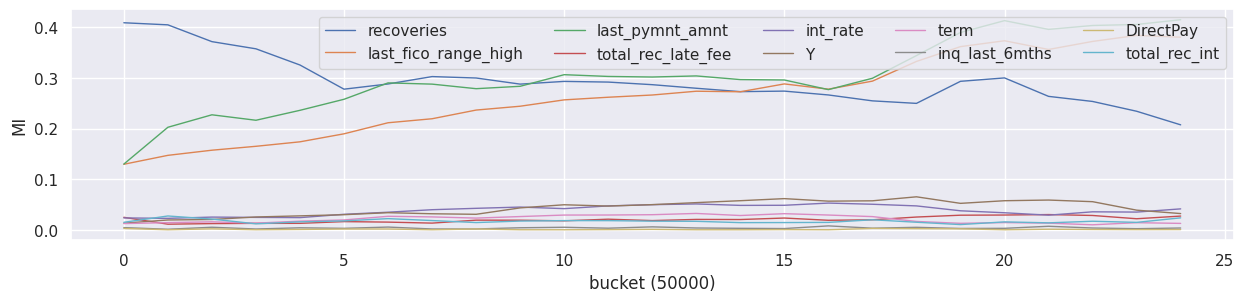

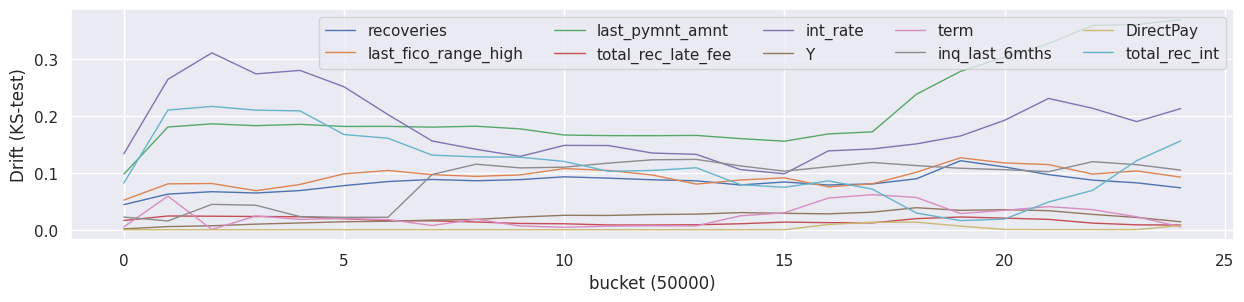

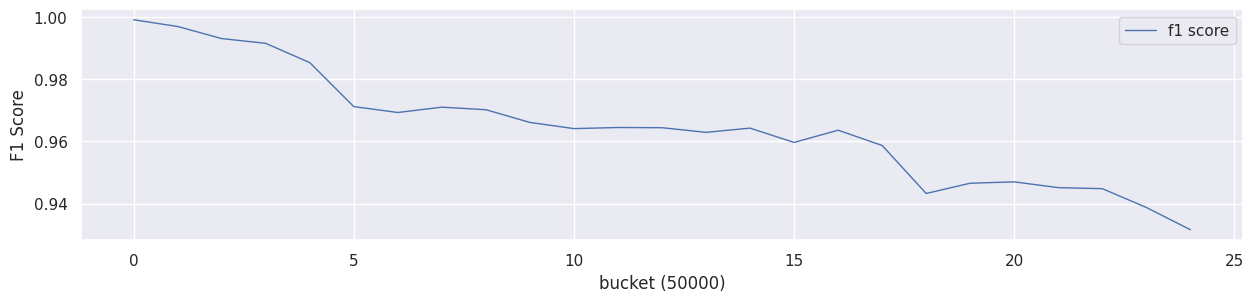

In [48]:
top_columns = list(mi_scores[0:10].index)
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 10) x_test: (10000, 10) x_live: (1278533, 10)
Uncertainty_drift: (y_train=(10000, 1), y_test=(10000, 1))
Testset metric ['acc', 'f1']:[99.96000000000001, 0.9997704315886135], Testset uncertainty : 0.00120
Noise set :  (400, 10000, 10)


100%|██████████| 400/400 [01:06<00:00,  6.03it/s]


Y Adjustment:0.32742
X Adjustment:-0.00080
Truncate 47492 rows from live_set (1278533, 10)
Live set :  (1106, 10000, 10)


100%|██████████| 1106/1106 [01:36<00:00, 11.49it/s]


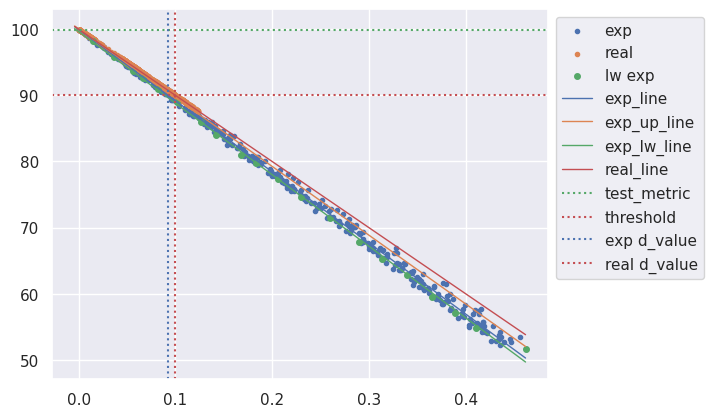

expected_uncertainty @ threshold 90 : 0.09248
    real_uncertainty @ threshold 90 : 0.10000
threshold error : 0.00752
################ 보정 처리 ###############


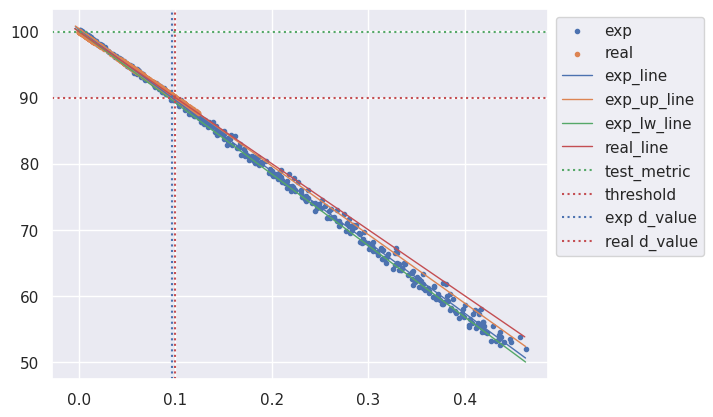

expected_uncertainty @ threshold 90 : 0.09632
    real_uncertainty @ threshold 90 : 0.10000
threshold error : 0.00368


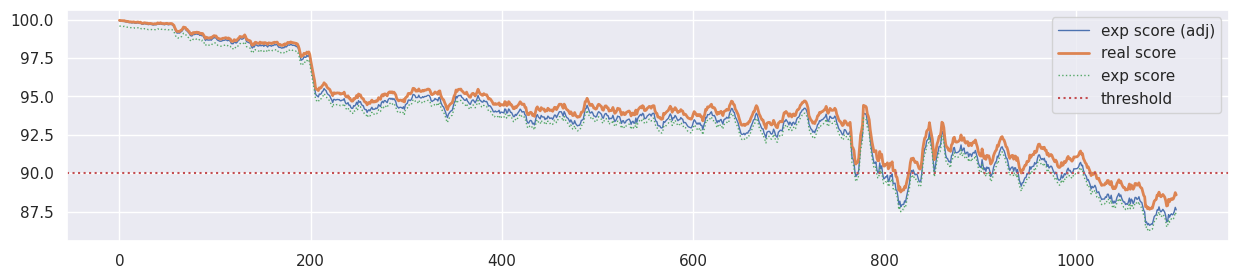

r2 of expected metric vs real metric :0.91223
Detect at 810 time, uncertainty 0.09830 metric 90.17000


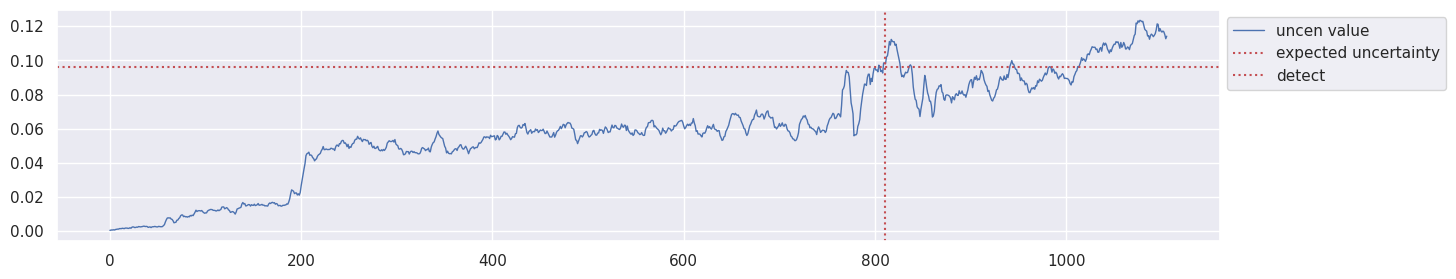

In [49]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=90)

# 도운 Dataset 실험

## 00.csv
+ 어떤 특성이 있는지 모름...

In [65]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/00.csv', index_col = 0)
data_00_df

time        C00        C01        C02        C03  D00  D01  \
0       55927.000000  65.965433  26.920842  12.770995  11.376428    8   21   
1       55927.006944  45.741756  36.375457   7.289673  46.325066   13    1   
2       55927.013889  90.143489  30.322969  10.091476  32.730630    8    4   
3       55927.020833  71.483239  15.346720   7.872696  31.377214    9   27   
4       55927.027778  78.145022  30.649774  12.219163  36.575666    8   13   
...              ...        ...        ...        ...        ...  ...  ...   
105259  56657.965278  47.500233   0.120889  15.151155   8.653207    5   16   
105260  56657.972222  44.540096  -0.232403  17.759726  18.393659    8    9   
105261  56657.979167  38.552870   0.210009  12.875184  13.340120   19   11   
105262  56657.986111  33.604683   0.092409  25.840889  22.857934   19   21   
105263  56657.993056  38.506056   0.181421  20.379221  20.741951   13   16   

        D02  D03  y  drift  
0        21    7  1    0.0  
1        20    6  1    0.0  
2        22    0  1    0.0  
3        21    4  1    0.0  
4        20    3  1    0.0  
...     ...  ... ..    ...  
105259    3   11  0    1.0  
105260   21    7  1    1.0  
105261    4   11  0    1.0  
105262    4   11  0    1.0  
105263    3    6  0    1.0  

[105264 rows x 11 columns]

In [51]:
data_00_df.drop(columns=['time','drift'],inplace=True)

In [66]:
data_00_df.shape

(105264, 11)

Max MI: 0.004133021110297674
Bucket size 1000 step_size 100


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


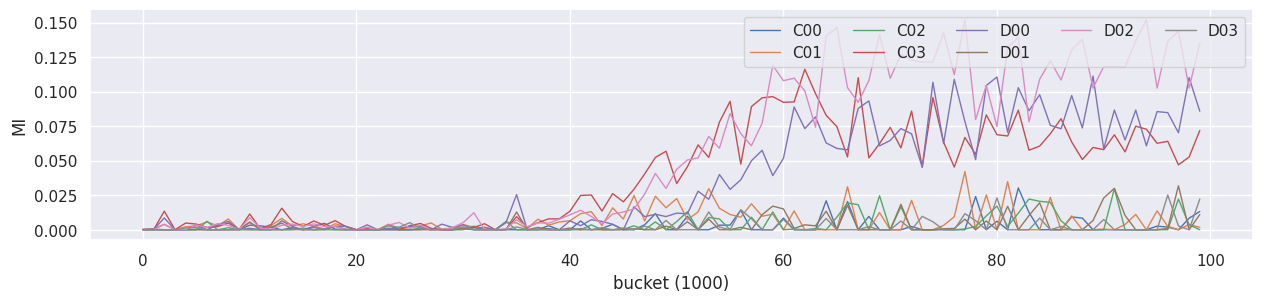

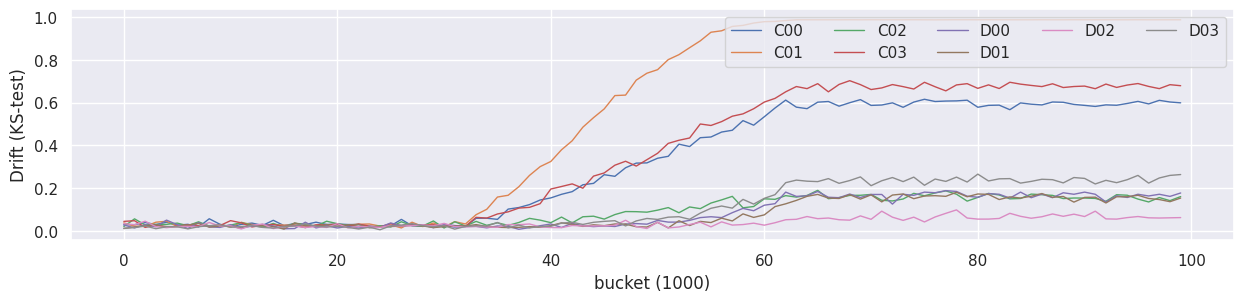

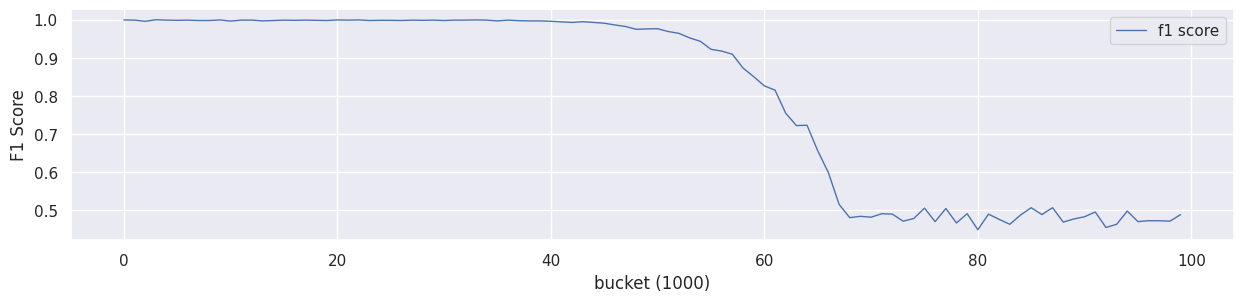

In [81]:
X2 = data_00_df[['C00','C01','C02','C03','D00','D01','D02','D03']]
Y2 = data_00_df['y']

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = ['C00','C01','C02','C03','D00','D01','D02','D03']
MI_Drift_F1(model, X2,Y2,4500,500,1000)

max_mi 0.0037612459769774675
Structure of dataset, x_train: (4500, 8) x_test: (4500, 8) x_live: (104764, 8)
[0, 265.86934386131236]
Uncertainty_drift: (y_train=(4500, 1), y_test=(4500, 1))
Testset metric ['acc', 'f1']:[99.8, 0.9989983305509181], Testset uncertainty : 0.00022
random_sigma_add, mean: [-2.30926389e-16  1.61845845e-17 -1.66582797e-16  4.50010399e-17
  3.94745964e-19 -9.55285234e-17 -1.04212935e-16  9.71075072e-17]
random_sigma_add, std: [1. 1. 1. 1. 1. 1. 1. 1.]
236.16325065937303
168.70118845053918
8.07990270299497
224.16762766990365
140.31768933790735
105.807291360361
41.505166251170856
122.18960048290799
115.03202477647129
206.9780767863833
158.1233312679582
122.40361510700129
80.22180953996526
220.41953757496893
17.17232205576507
98.07261392871824
191.43534742708272
26.769680444447765
152.043240255002
230.5715529386927
137.46366439534148
206.02111025242857
20.142860348269572
36.09464993787028
193.51439317523653
210.05037299657732
35.08955414084978
52.95780294353916
73.

100%|██████████| 400/400 [00:35<00:00, 11.22it/s]


Y Adjustment:0.00773
X Adjustment:0.00156
Truncate 20112 rows from live_set (104764, 8)
Live set :  (201, 4500, 8)


100%|██████████| 201/201 [00:09<00:00, 21.29it/s]


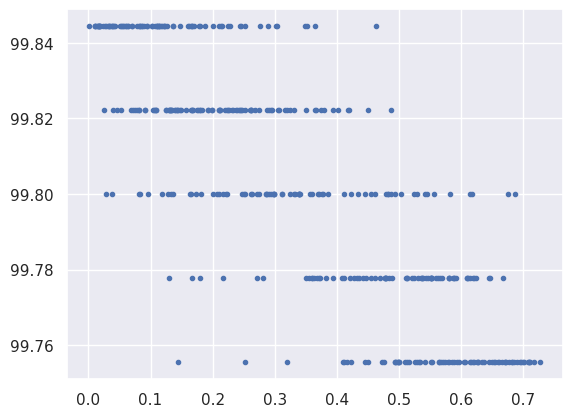

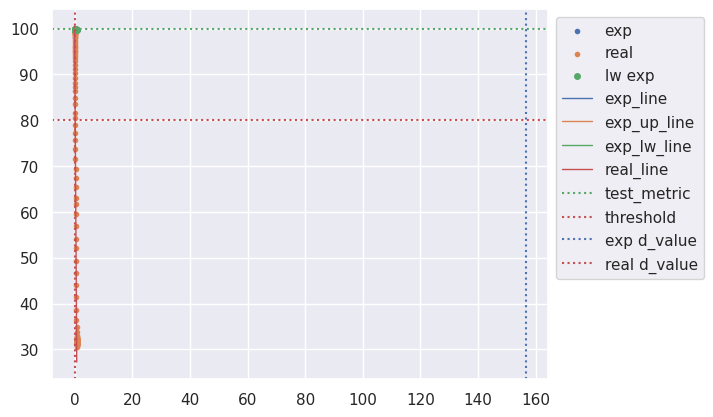

expected_uncertainty @ threshold 80 : 156.48815
    real_uncertainty @ threshold 80 : 0.20000
threshold error : 156.28815
################ 보정 처리 ###############


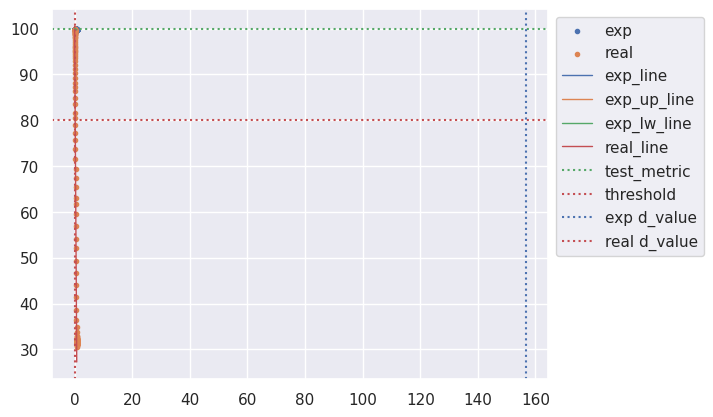

expected_uncertainty @ threshold 80 : 156.54753
    real_uncertainty @ threshold 80 : 0.20000
threshold error : 156.34753


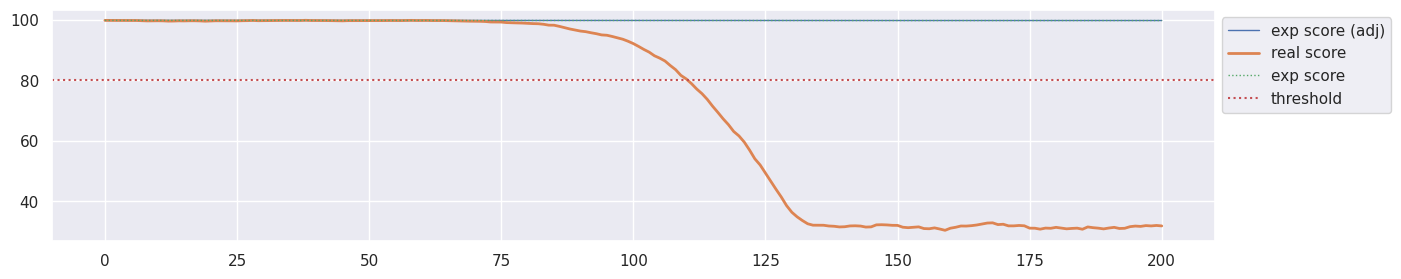

r2 of expected metric vs real metric :-0.85245
Detect fail!!


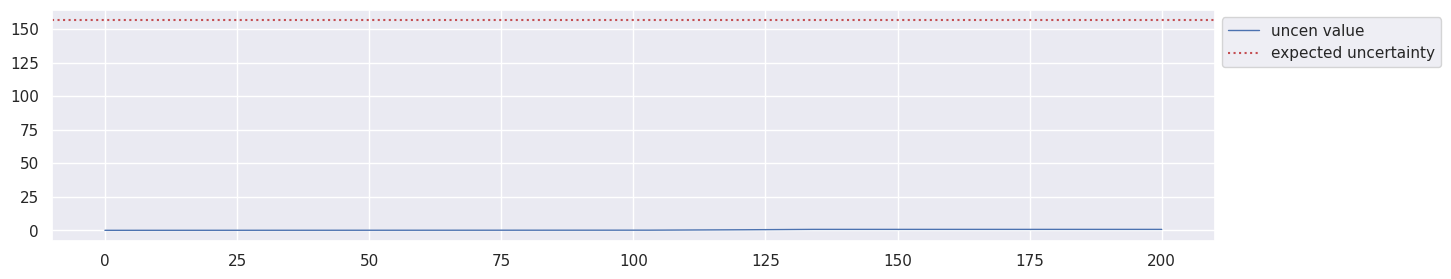

In [95]:
train_size = 4500
test_size = 500

experiment(X2.values,Y2.values,train_size,test_size,threshold=80)

## sine_0123_gradual

In [58]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/sine_0123_gradual.csv')
data_00_df

X1        X2  class
0      0.017490  0.891573    1.0
1      0.792034  0.324471    0.0
2      0.112312  0.141897    1.0
3      0.132102  0.037110    0.0
4      0.081988  0.213440    1.0
...         ...       ...    ...
40995  0.899356  0.539090    1.0
40996  0.269991  0.151515    0.0
40997  0.842951  0.876155    1.0
40998  0.541211  0.315449    0.0
40999  0.901501  0.690306    1.0

[41000 rows x 3 columns]

Bucket size 400 step_size 91


100%|██████████| 91/91 [00:02<00:00, 35.80it/s]


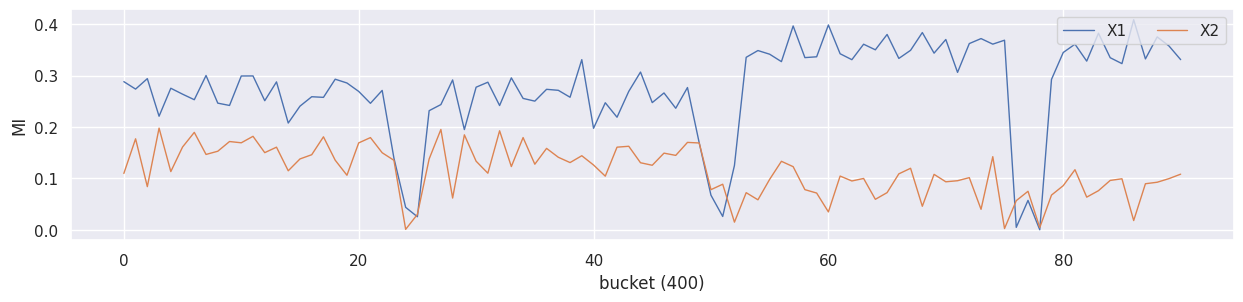

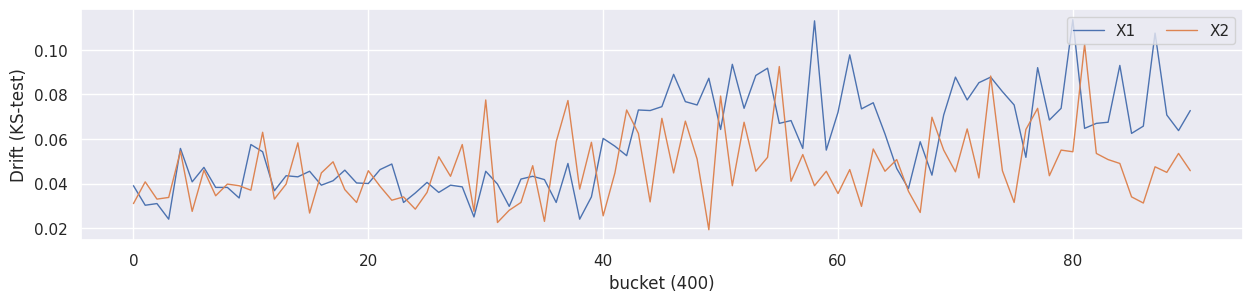

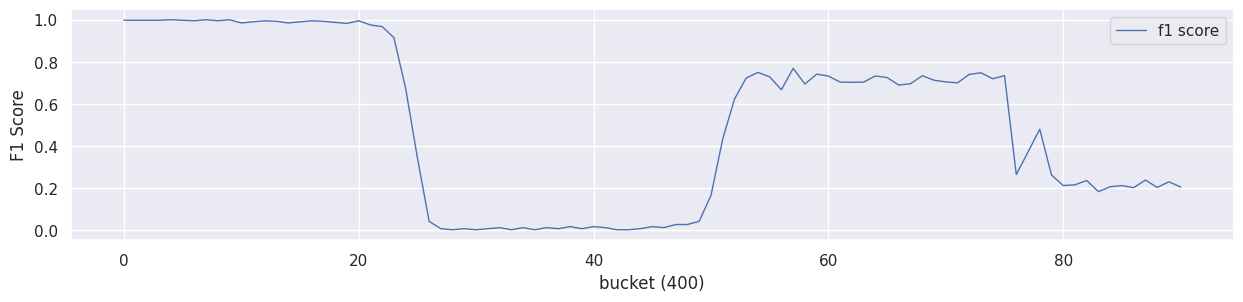

In [59]:
X2 = data_00_df[['X1','X2']]
Y2 = data_00_df['class']
model = RandomForestClassifier(max_depth=6).fit(X2[0:4000].values, Y2[0:4000])

columns = ['X1','X2']
MI_Drift_F1(model, X2,Y2,4000,400,400)

Structure of dataset, x_train: (4000, 2) x_test: (4000, 2) x_live: (40600, 2)
Uncertainty_drift: (y_train=(4000, 1), y_test=(4000, 1))
Testset metric ['acc', 'f1']:[99.625, 0.9962546816479401], Testset uncertainty : 0.00000
Noise set :  (400, 4000, 2)


100%|██████████| 400/400 [00:37<00:00, 10.60it/s]


Y Adjustment:4.41404
X Adjustment:0.00025
Truncate 19800 rows from live_set (40600, 2)
Live set :  (92, 4000, 2)


100%|██████████| 92/92 [00:04<00:00, 20.50it/s]


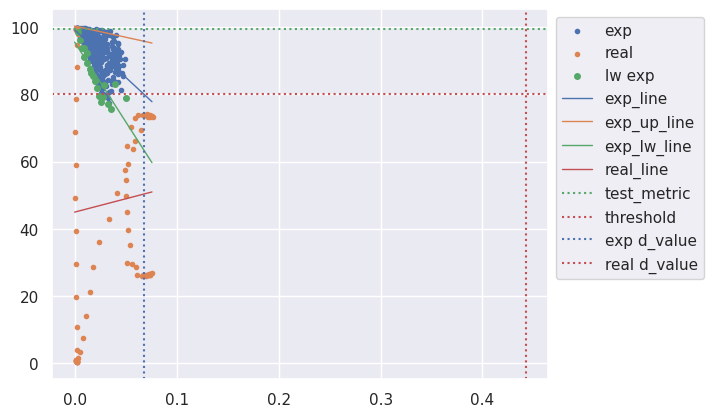

expected_uncertainty @ threshold 80 : 0.06752
    real_uncertainty @ threshold 80 : 0.44234
threshold error : 0.37481
################ 보정 처리 ###############


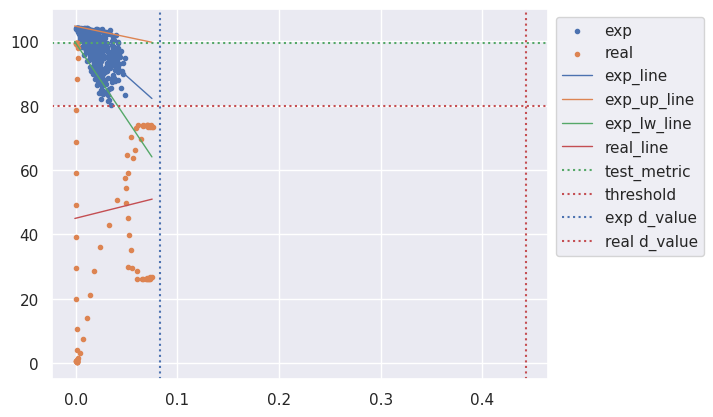

expected_uncertainty @ threshold 80 : 0.08296
    real_uncertainty @ threshold 80 : 0.44234
threshold error : 0.35938


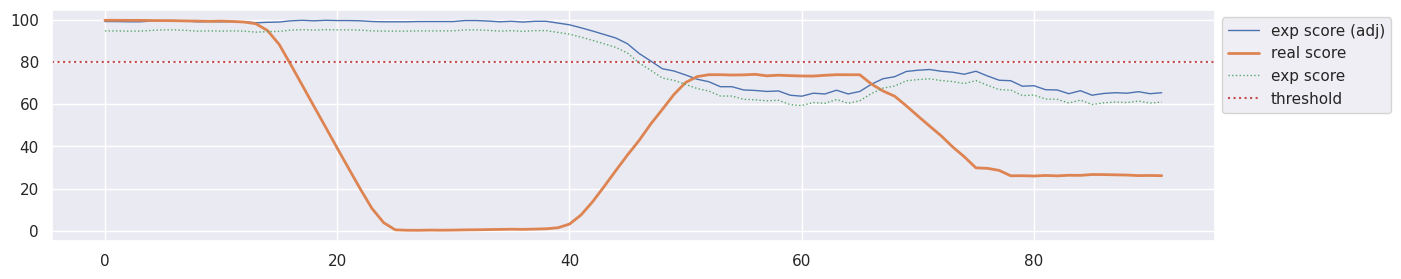

r2 of expected metric vs real metric :-1.14180
Detect fail!!


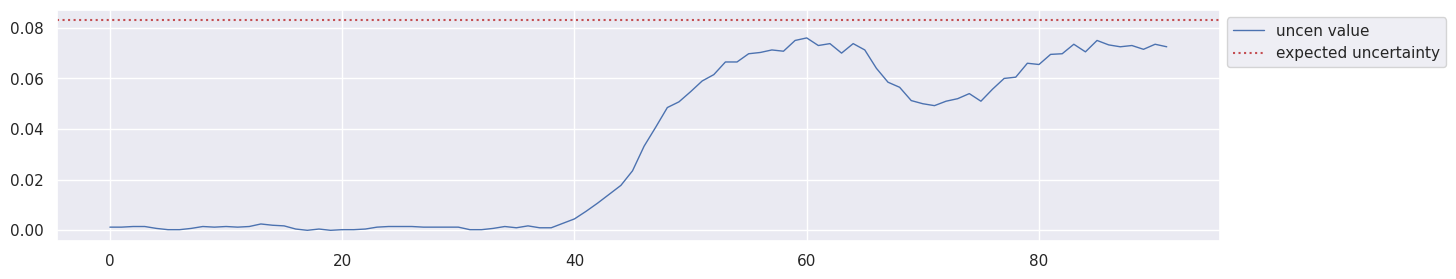

In [60]:
train_size = 4000
test_size = 400

experiment(X2.values,Y2.values,train_size,test_size,threshold=80)

## mixed_0101_gradual.csv

In [61]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/mixed_0101_gradual.csv')
data_00_df

X1   X2        X3        X4  class
0      0.0  1.0  0.460101  0.592744    1.0
1      1.0  1.0  0.588788  0.574984    0.0
2      0.0  0.0  0.401641  0.679325    1.0
3      1.0  1.0  0.306076  0.182108    0.0
4      0.0  0.0  0.962847  0.579245    1.0
...    ...  ...       ...       ...    ...
40995  0.0  1.0  0.802194  0.308799    1.0
40996  0.0  0.0  0.509831  0.060636    0.0
40997  0.0  1.0  0.430608  0.025524    1.0
40998  0.0  0.0  0.867294  0.044091    0.0
40999  1.0  1.0  0.670322  0.221267    1.0

[41000 rows x 5 columns]

Bucket size 400 step_size 91


100%|██████████| 91/91 [00:03<00:00, 29.86it/s]


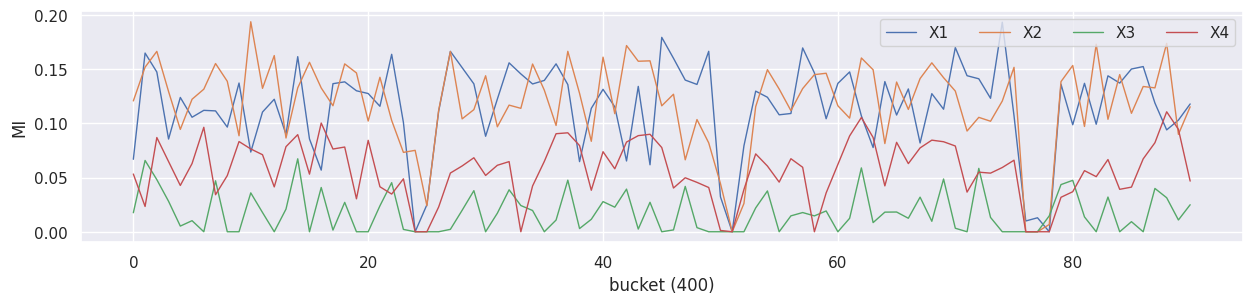

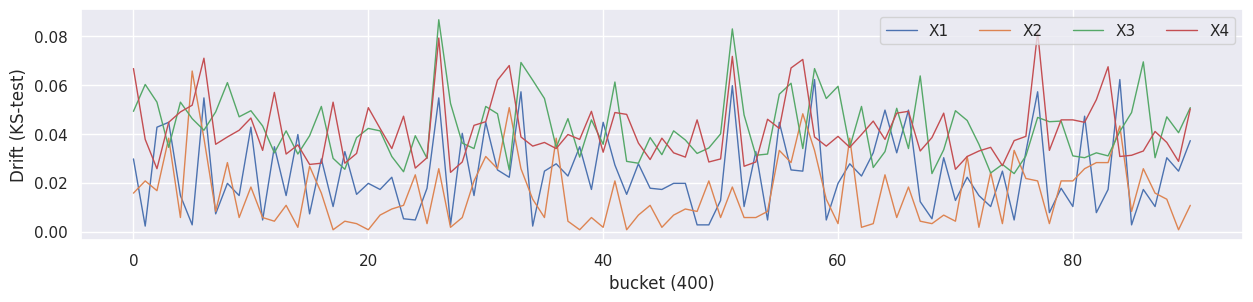

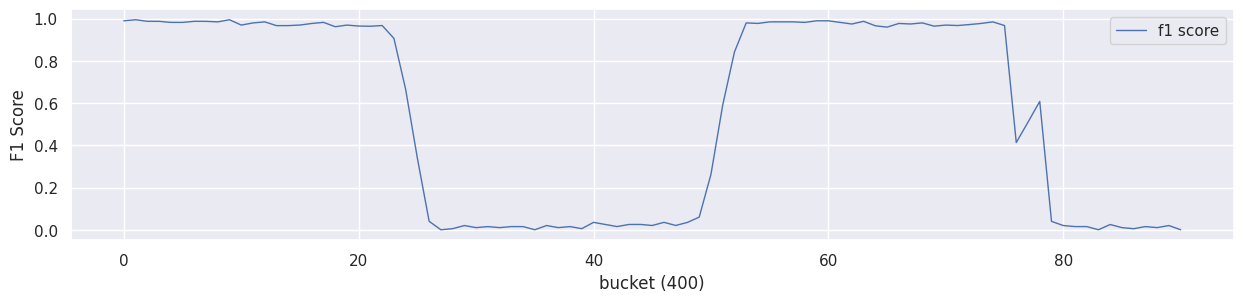

In [62]:
X2 = data_00_df[['X1','X2','X3','X4']]
Y2 = data_00_df['class']
model = RandomForestClassifier(max_depth=6).fit(X2[0:4000].values, Y2[0:4000])

columns = ['X1','X2','X3','X4']
MI_Drift_F1(model, X2,Y2,4000,400,400)

Structure of dataset, x_train: (4000, 4) x_test: (4000, 4) x_live: (40600, 4)
Uncertainty_drift: (y_train=(4000, 1), y_test=(4000, 1))
Testset metric ['acc', 'f1']:[98.5, 0.9850224663005492], Testset uncertainty : 0.00000
Noise set :  (400, 4000, 4)


100%|██████████| 400/400 [00:39<00:00, 10.09it/s]


Y Adjustment:0.48267
X Adjustment:0.00025
Truncate 19800 rows from live_set (40600, 4)
Live set :  (92, 4000, 4)


100%|██████████| 92/92 [00:04<00:00, 19.99it/s]


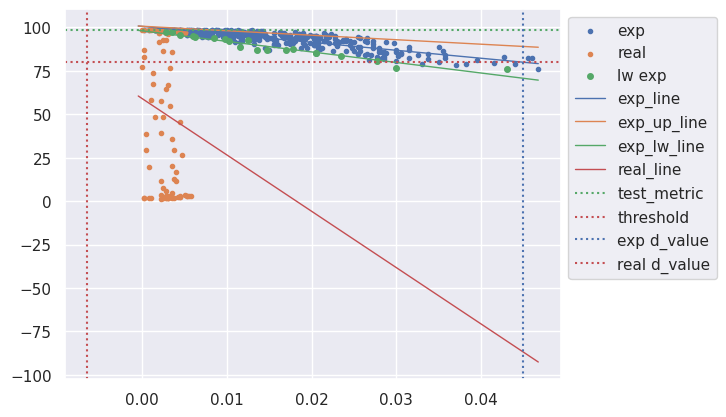

expected_uncertainty @ threshold 80 : 0.04490
    real_uncertainty @ threshold 80 : -0.00647
threshold error : 0.05138
################ 보정 처리 ###############


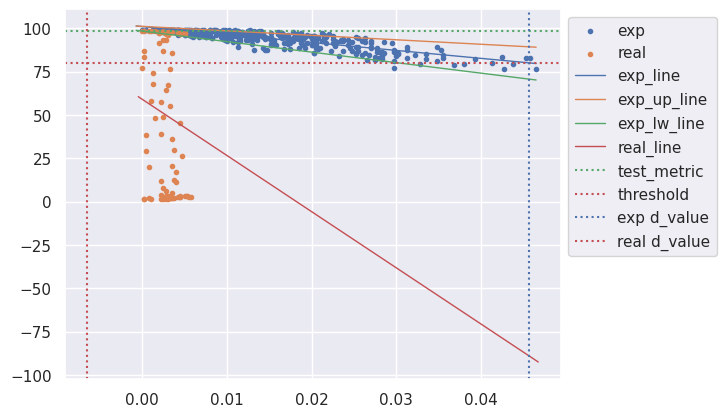

expected_uncertainty @ threshold 80 : 0.04571
    real_uncertainty @ threshold 80 : -0.00647
threshold error : 0.05218


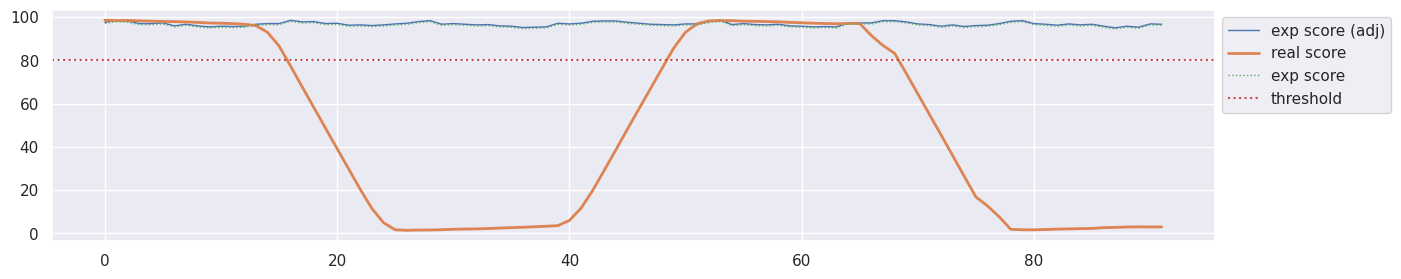

r2 of expected metric vs real metric :-1.24477
Detect fail!!


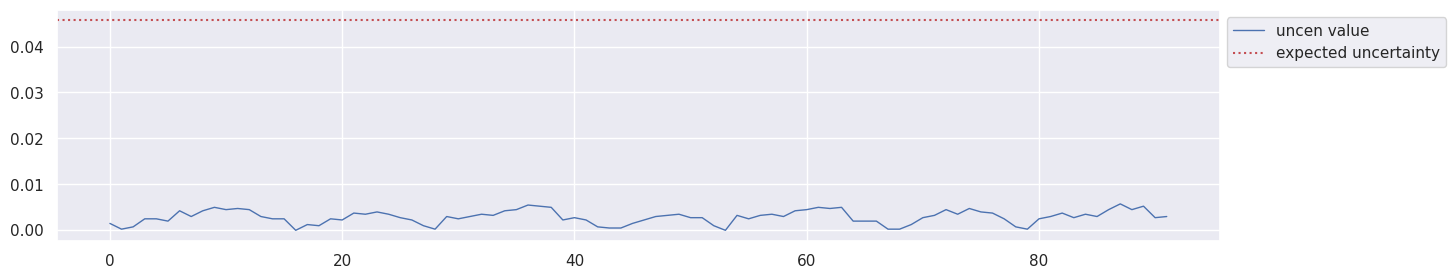

In [63]:
train_size = 4000
test_size = 400

experiment(X2.values,Y2.values,train_size,test_size,threshold=80)